# Исследовательский анализ данных в Python и проверка гипотез. Знакомство с данными

Автор: Дмитриев Марк
Дата:23.09.2025

## Описание данных

Первый датасет final_tickets_orders_df.csv включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Поля датасета соответствуют таблице purchases, с которой вы работали в предыдущих заданиях:

- order_id — уникальный идентификатор заказа.
- user_id — уникальный идентификатор пользователя.
- created_dt_msk — дата создания заказа (московское время).
- created_ts_msk — дата и время создания заказа (московское время).
- event_id — идентификатор мероприятия из таблицы events.
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- age_limit — возрастное ограничение мероприятия.
- currency_code — валюта оплаты, например rub для российских рублей.
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- revenue — выручка от заказа.
- service_name — название билетного оператора.
- tickets_count — количество купленных билетов.
- total — общая сумма заказа.


В данные также был добавлен столбец days_since_prev с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет final_tickets_events_df.csv содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Датасет содержит такие поля:


- event_id — уникальный идентификатор мероприятия.
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- event_type_description — описание типа мероприятия.
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
- organizers — организаторы мероприятия.
- region_name — название региона.
- city_name — название города.
- venue_id — уникальный идентификатор площадки.
- venue_name — название площадки.
- venue_address — адрес площадки.


Выручка от заказов может бы представлена в разных валютах. Удобно будет привести данные к одной — к российским рублям. В вашем распоряжении будет датасет final_tickets_tenge_df.csv с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:


- nominal — номинал (100 тенге);
- data — дата;
- curs — курс тенге к рублю;
- cdx — обозначение валюты (kzt).

## Загрузка данных и знакомство с ними

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
from datetime import datetime, timedelta

In [3]:
from matplotlib.ticker import PercentFormatter

In [4]:
final_tickets_orders=pd.read_csv('/datasets/final_tickets_orders_df.csv')
final_tickets_orders.head(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [5]:
print("=== final_tickets_orders ===")
print(f"Размер данных: {final_tickets_orders.shape}")
print("\nИнформация о данных:")
print(final_tickets_orders.info())
print("\nОписательная статистика:")
print(final_tickets_orders.describe())
print("\nПропущенные значения:")
print(final_tickets_orders.isnull().sum())

=== final_tickets_orders ===
Размер данных: (290849, 14)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since

In [6]:
final_tickets_events=pd.read_csv('/datasets/final_tickets_events_df.csv')
final_tickets_events.head(5)

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [7]:
print("\n=== final_tickets_events ===")
print(f"Размер данных: {final_tickets_events.shape}")
print("\nИнформация о данных:")
print(final_tickets_events.info())
print("\nПропущенные значения:")
print(final_tickets_events.isnull().sum())


=== final_tickets_events ===
Размер данных: (22427, 11)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB
None

Пропущенные значения:
event_id                  0
event_name                0
ev

In [8]:
final_tickets_tenge=pd.read_csv('/datasets/final_tickets_tenge_df.csv')
final_tickets_tenge.head(5)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [9]:
print("\n=== final_tickets_tenge ===")
print(f"Размер данных: {final_tickets_tenge.shape}")
print("\nИнформация о данных:")
print(final_tickets_tenge.info())
print("\nПропущенные значения:")
print(final_tickets_tenge.isnull().sum())


=== final_tickets_tenge ===
Размер данных: (357, 4)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None

Пропущенные значения:
data       0
nominal    0
curs       0
cdx        0
dtype: int64


Во всех таблицах нет пропусков, кроме столбца days_since_prev 21940 в таблицк final_tickets_orders

## Предобработка данных и подготовка их к исследованию

In [10]:
merged_df = final_tickets_orders.merge(final_tickets_events, on='event_id', how='left')
merged_df.head(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


In [11]:
# Проверим столбец 'cinema_circuit' более детально
print("Детальный анализ cinema_circuit:")
print(merged_df['cinema_circuit'].value_counts(dropna=False))
print(f"Процент значения 'нет': {merged_df['cinema_circuit'].value_counts(normalize=True).get('нет', 0)*100:.2f}%")

# Проверим столбец 'organizers'
print("\nДетальный анализ organizers:")
org_counts = merged_df['organizers'].value_counts()
print(f"Всего уникальных организаторов: {len(org_counts)}")
print("Топ-10 организаторов:")
print(org_counts.head(10))
# Анализ currency_code
print("\n АНАЛИЗ currency_code:")
currency_analysis = merged_df['currency_code'].value_counts()
print(currency_analysis)
# Анализ device_type_canonical
print("\n АНАЛИЗ device_type_canonical:")
device_analysis = merged_df['device_type_canonical'].value_counts()
print(device_analysis)
# Анализ age_limit - хотя числовой, но может быть категориальным
print("\n АНАЛИЗ age_limit:")
age_analysis = merged_df['age_limit'].value_counts().sort_index()
print(age_analysis)
# Анализ event_type_description и event_type_main
print("\n АНАЛИЗ ТИПОВ СОБЫТИЙ:")
print("event_type_description:")
print(merged_df['event_type_description'].value_counts())
print("\nevent_type_main:")
print(merged_df['event_type_main'].value_counts())
#Анализ географических данных
print("\n АНАЛИЗ ГЕОГРАФИЧЕСКИХ ДАННЫХ:")
print("region_name - уникальные регионы:")
print(merged_df['region_name'].value_counts().head(10))
print(f"\nВсего уникальных регионов: {merged_df['region_name'].nunique()}")

print("\ncity_name - уникальные города:")
print(merged_df['city_name'].value_counts().head(10))
print(f"\nВсего уникальных городов: {merged_df['city_name'].nunique()}")

# Анализ venue_name и venue_address
print("\n АНАЛИЗ МЕСТ ПРОВЕДЕНИЯ:")
print("venue_name - примеры названий:")
print(merged_df['venue_name'].value_counts().head(10))
print(f"\nВсего уникальных мест: {merged_df['venue_name'].nunique()}")

Детальный анализ cinema_circuit:
нет           289451
Другое          1261
КиноСити         122
Москино            7
Киномакс           7
ЦентрФильм         1
Name: cinema_circuit, dtype: int64
Процент значения 'нет': 99.52%

Детальный анализ organizers:
Всего уникальных организаторов: 4293
Топ-10 организаторов:
№1531    9748
№2121    4738
№4054    4362
№4549    3972
№4837    3368
№4086    3323
№4950    3212
№4403    3037
№5085    3005
№2378    2886
Name: organizers, dtype: int64

 АНАЛИЗ currency_code:
rub    285780
kzt      5069
Name: currency_code, dtype: int64

 АНАЛИЗ device_type_canonical:
mobile     232679
desktop     58170
Name: device_type_canonical, dtype: int64

 АНАЛИЗ age_limit:
0     61487
6     52173
12    62557
16    78579
18    36053
Name: age_limit, dtype: int64

 АНАЛИЗ ТИПОВ СОБЫТИЙ:
event_type_description:
концерт                   112049
событие                    58605
спектакль                  50592
шоу                        13626
спорт                      12

cinema_circuit:

* большинство значений имеет статус "нет" что говорит о том что кинотеатры не входят в сеть

currency_code:
* разделение валют на kzt и rub 

device_type_canonical:
* разделение на мобильные и десктопные устройиства

age_limit:

* всего 5 категорий возрастной группы

самое популярное событие:
* концерты

всего регионов 81, самый популярный Каменевский

всего городов 352, самый популярный Глиногорск

In [12]:
# Разделим данные по валютам
rub_data = merged_df[merged_df['currency_code'] == 'rub']
kzt_data = merged_df[merged_df['currency_code'] == 'kzt'] if 'kzt' in merged_df['currency_code'].values else None
other_currencies = merged_df[~merged_df['currency_code'].isin(['rub', 'kzt'])] if 'kzt' in merged_df['currency_code'].values else merged_df[merged_df['currency_code'] != 'RUB']

print("РАСПРЕДЕЛЕНИЕ ПО ВАЛЮТАМ:")
print(f"rub: {len(rub_data)} записей ({len(rub_data)/len(merged_df)*100:.1f}%)")
if kzt_data is not None:
    print(f"kzt: {len(kzt_data)} записей ({len(kzt_data)/len(merged_df)*100:.1f}%)")
if len(other_currencies) > 0:
    print(f"Другие валюты: {len(other_currencies)} записей")

# Статистика по revenue для каждой валюты
print("\nСТАТИСТИКА REVENUE ПО ВАЛЮТАМ:")
print("\nrub:")
print(rub_data['revenue'].describe())

if kzt_data is not None:
    print("\nkzt:")
    print(kzt_data['revenue'].describe())

if len(other_currencies) > 0:
    print("\nДругие валюты:")
    print(other_currencies['revenue'].describe())

РАСПРЕДЕЛЕНИЕ ПО ВАЛЮТАМ:
rub: 285780 записей (98.3%)
kzt: 5069 записей (1.7%)

СТАТИСТИКА REVENUE ПО ВАЛЮТАМ:

rub:
count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

kzt:
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


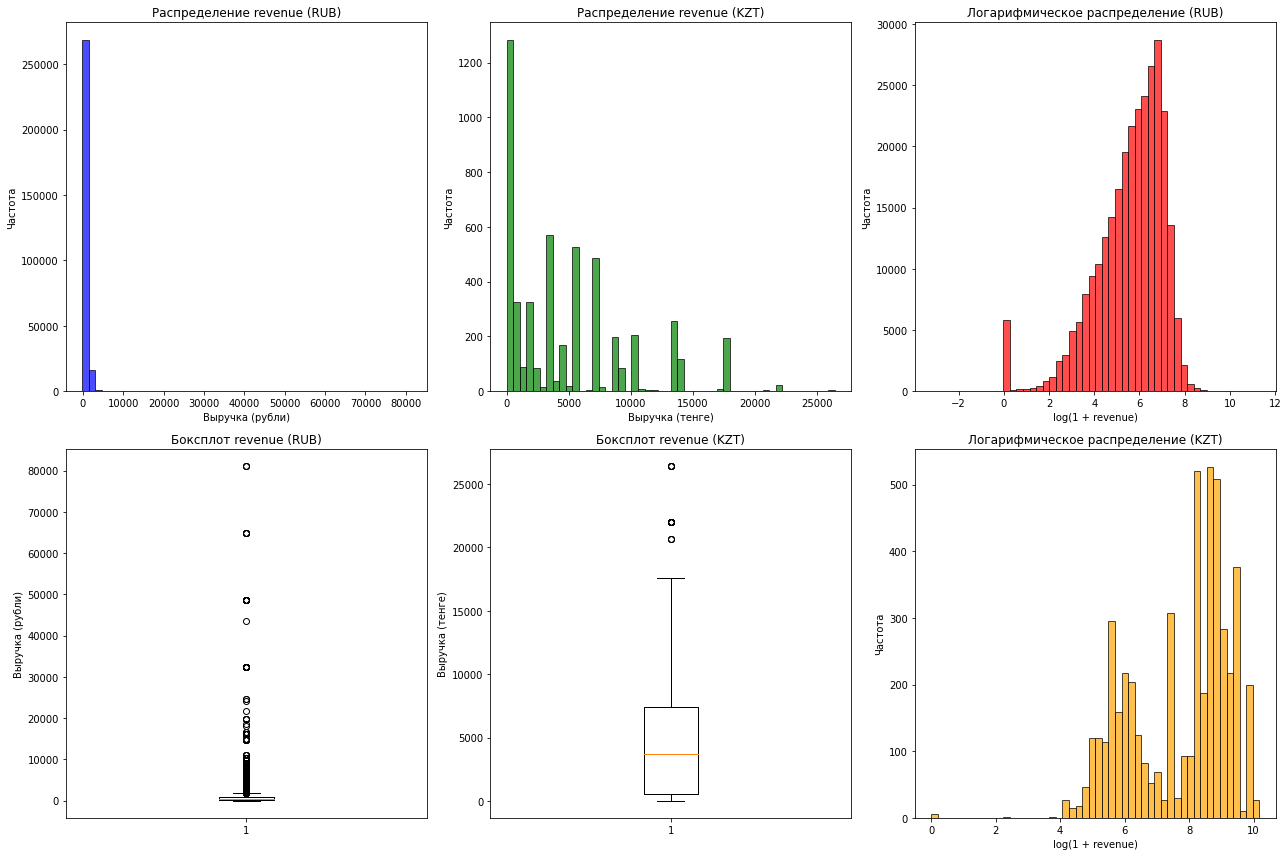

In [13]:
# Создаем графики для анализа распределения
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Гистограммы распределения
# RUB
axes[0, 0].hist(rub_data['revenue'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Распределение revenue (RUB)')
axes[0, 0].set_xlabel('Выручка (рубли)')
axes[0, 0].set_ylabel('Частота')

# KZT (если есть)
if kzt_data is not None:
    axes[0, 1].hist(kzt_data['revenue'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('Распределение revenue (KZT)')
    axes[0, 1].set_xlabel('Выручка (тенге)')
    axes[0, 1].set_ylabel('Частота')

# Боксплоты для выявления выбросов
# RUB
axes[1, 0].boxplot(rub_data['revenue'])
axes[1, 0].set_title('Боксплот revenue (RUB)')
axes[1, 0].set_ylabel('Выручка (рубли)')

# KZT (если есть)
if kzt_data is not None:
    axes[1, 1].boxplot(kzt_data['revenue'])
    axes[1, 1].set_title('Боксплот revenue (KZT)')
    axes[1, 1].set_ylabel('Выручка (тенге)')

# Логарифмическое распределение для лучшей визуализации
axes[0, 2].hist(np.log1p(rub_data['revenue']), bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0, 2].set_title('Логарифмическое распределение (RUB)')
axes[0, 2].set_xlabel('log(1 + revenue)')
axes[0, 2].set_ylabel('Частота')

if kzt_data is not None:
    axes[1, 2].hist(np.log1p(kzt_data['revenue']), bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 2].set_title('Логарифмическое распределение (KZT)')
    axes[1, 2].set_xlabel('log(1 + revenue)')
    axes[1, 2].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [14]:
# Функция для анализа выбросов по перцентилям
def analyze_outliers(data, currency_name):
    print(f"\nАНАЛИЗ ВЫБРОСОВ ДЛЯ {currency_name}:")
    print("="*40)
    
    # Рассчитаем различные перцентили
    percentiles = [25, 50, 75, 90, 95, 99, 99.5, 99.9, 99.99]
    percentile_values = np.percentile(data['revenue'], percentiles)
    
    for p, val in zip(percentiles, percentile_values):
        print(f"{p}%-й перцентиль: {val:.2f}")
    
    # Определим выбросы по 99-му перцентилю
    threshold_99 = np.percentile(data['revenue'], 99)
    outliers_99 = data[data['revenue'] > threshold_99]
    
    print(f"\nПорог по 99-му перцентилю: {threshold_99:.2f}")
    print(f"Количество выбросов (>99%): {len(outliers_99)}")
    print(f"Доля выбросов: {len(outliers_99)/len(data)*100:.2f}%")
    
    # Статистика по выбросам
    if len(outliers_99) > 0:
        print(f"Мин. значение выбросов: {outliers_99['revenue'].min():.2f}")
        print(f"Макс. значение выбросов: {outliers_99['revenue'].max():.2f}")
        print(f"Среднее значение выбросов: {outliers_99['revenue'].mean():.2f}")
    
    return threshold_99, outliers_99

# Анализ для RUB
threshold_rub, outliers_rub = analyze_outliers(rub_data, "RUB")

# Анализ для KZT (если есть)
if kzt_data is not None:
    threshold_kzt, outliers_kzt = analyze_outliers(kzt_data, "KZT")


АНАЛИЗ ВЫБРОСОВ ДЛЯ RUB:
25%-й перцентиль: 113.83
50%-й перцентиль: 346.10
75%-й перцентиль: 791.70
90%-й перцентиль: 1276.15
95%-й перцентиль: 1606.50
99%-й перцентиль: 2569.59
99.5%-й перцентиль: 2988.16
99.9%-й перцентиль: 5140.78
99.99%-й перцентиль: 32469.82

Порог по 99-му перцентилю: 2569.59
Количество выбросов (>99%): 2858
Доля выбросов: 1.00%
Мин. значение выбросов: 2569.61
Макс. значение выбросов: 81174.54
Среднее значение выбросов: 4269.81

АНАЛИЗ ВЫБРОСОВ ДЛЯ KZT:
25%-й перцентиль: 518.10
50%-й перцентиль: 3698.83
75%-й перцентиль: 7397.66
90%-й перцентиль: 13212.93
95%-й перцентиль: 13784.26
99%-й перцентиль: 17617.24
99.5%-й перцентиль: 21564.20
99.9%-й перцентиль: 22021.55
99.99%-й перцентиль: 26425.86

Порог по 99-му перцентилю: 17617.24
Количество выбросов (>99%): 29
Доля выбросов: 0.57%
Мин. значение выбросов: 20676.39
Макс. значение выбросов: 26425.86
Среднее значение выбросов: 22641.76



АНАЛИЗ TICKETS_COUNT
Общая статистика tickets_count:
count    290849.000000
mean          2.754230
std           1.170467
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Tickets_count по валютам:
RUB:
count    285780.000000
mean          2.754077
std           1.171419
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

KZT:
count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: tickets_count, dtype: float64


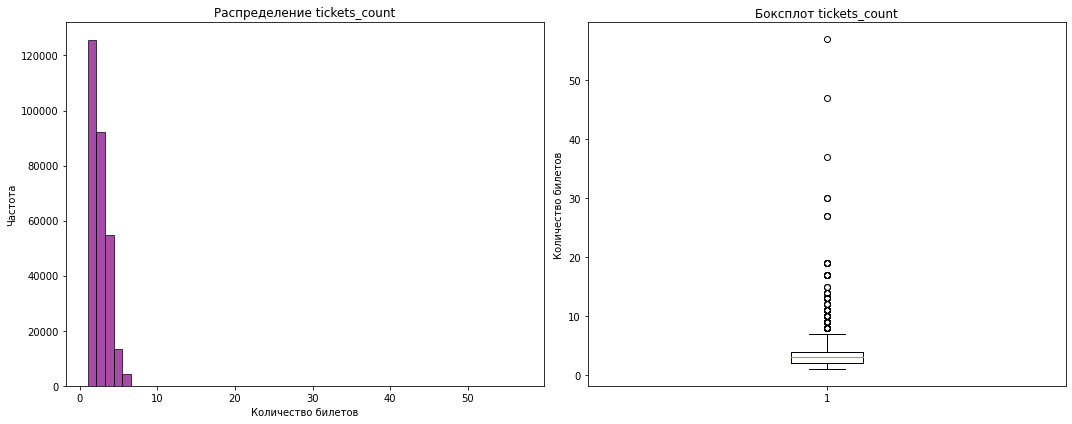


Выбросы в tickets_count (>99%):
Порог: 6.0 билетов
Количество выбросов: 188
Максимальное значение: 57 билетов


In [15]:
# Проверим наличие tickets_count и проанализируем его
if 'tickets_count' in merged_df.columns:
    print("\n" + "="*50)
    print("АНАЛИЗ TICKETS_COUNT")
    print("="*50)
    
    # Основная статистика
    print("Общая статистика tickets_count:")
    print(merged_df['tickets_count'].describe())
    
    # Распределение по валютам
    print("\nTickets_count по валютам:")
    print("RUB:")
    print(rub_data['tickets_count'].describe())
    
    if kzt_data is not None:
        print("\nKZT:")
        print(kzt_data['tickets_count'].describe())
    
    # Визуализация распределения tickets_count
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Гистограмма
    axes[0].hist(merged_df['tickets_count'], bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[0].set_title('Распределение tickets_count')
    axes[0].set_xlabel('Количество билетов')
    axes[0].set_ylabel('Частота')
    
    # Боксплот
    axes[1].boxplot(merged_df['tickets_count'])
    axes[1].set_title('Боксплот tickets_count')
    axes[1].set_ylabel('Количество билетов')
    
    plt.tight_layout()
    plt.show()
    
    # Анализ выбросов в tickets_count
    tickets_threshold_99 = np.percentile(merged_df['tickets_count'], 99)
    tickets_outliers = merged_df[merged_df['tickets_count'] > tickets_threshold_99]
    
    print(f"\nВыбросы в tickets_count (>99%):")
    print(f"Порог: {tickets_threshold_99} билетов")
    print(f"Количество выбросов: {len(tickets_outliers)}")
    print(f"Максимальное значение: {merged_df['tickets_count'].max()} билетов")
    
else:
    print("Столбец tickets_count отсутствует в данных")

In [16]:
# Создаем отфильтрованные датафреймы без выбросов
print("\n" + "="*50)
print("ФИЛЬТРАЦИЯ ДАННЫХ ПО 99-МУ ПЕРЦЕНТИЛЮ")
print("="*50)

# Фильтруем RUB данные
filtered_rub_data = rub_data[rub_data['revenue'] <= threshold_rub]
print(f"RUB данные до фильтрации: {len(rub_data)} записей")
print(f"RUB данные после фильтрации: {len(filtered_rub_data)} записей")
print(f"Удалено записей RUB: {len(rub_data) - len(filtered_rub_data)}")

# Фильтруем KZT данные (если есть)
if kzt_data is not None:
    filtered_kzt_data = kzt_data[kzt_data['revenue'] <= threshold_kzt]
    print(f"\nKZT данные до фильтрации: {len(kzt_data)} записей")
    print(f"KZT данные после фильтрации: {len(filtered_kzt_data)} записей")
    print(f"Удалено записей KZT: {len(kzt_data) - len(filtered_kzt_data)}")

# Объединяем отфильтрованные данные
filtered_data_list = [filtered_rub_data]
if kzt_data is not None:
    filtered_data_list.append(filtered_kzt_data)
if len(other_currencies) > 0:
    filtered_data_list.append(other_currencies)

filtered_df = pd.concat(filtered_data_list, ignore_index=True)

print(f"\nОбщий размер данных до фильтрации: {len(merged_df)}")
print(f"Общий размер данных после фильтрации: {len(filtered_df)}")
print(f"Общее количество удаленных выбросов: {len(merged_df) - len(filtered_df)}")


ФИЛЬТРАЦИЯ ДАННЫХ ПО 99-МУ ПЕРЦЕНТИЛЮ
RUB данные до фильтрации: 285780 записей
RUB данные после фильтрации: 282922 записей
Удалено записей RUB: 2858

KZT данные до фильтрации: 5069 записей
KZT данные после фильтрации: 5040 записей
Удалено записей KZT: 29

Общий размер данных до фильтрации: 290849
Общий размер данных после фильтрации: 287962
Общее количество удаленных выбросов: 2887



СРАВНЕНИЕ СТАТИСТИК ДО И ПОСЛЕ ФИЛЬТРАЦИИ
REVENUE (RUB) - ДО фильтрации:
count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

REVENUE (RUB) - ПОСЛЕ фильтрации:
count    282922.000000
mean        509.967304
std         500.112654
min         -90.760000
25%         111.660000
50%         340.250000
75%         781.090000
max        2569.590000
Name: revenue, dtype: float64

REVENUE (KZT) - ДО фильтрации:
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

REVENUE (KZT) - ПОСЛЕ фильтрации:
count     5040.000000
mean      4893.669063
std       4742.680176
min          0.000000
25%        515.350000
50%       3698.830000
75%       7397.660000
max      17617.240000
Name: revenue,

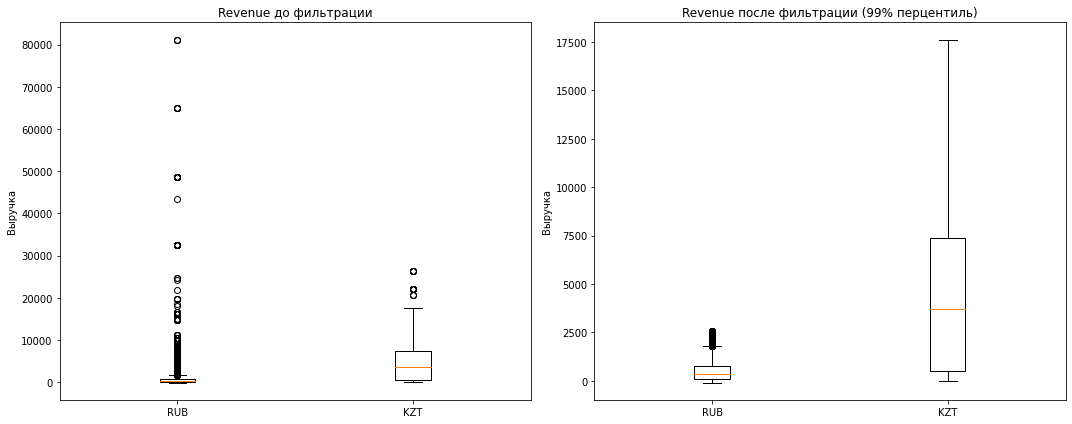

In [17]:
# Сравним статистики до и после фильтрации
print("\n" + "="*50)
print("СРАВНЕНИЕ СТАТИСТИК ДО И ПОСЛЕ ФИЛЬТРАЦИИ")
print("="*50)

print("REVENUE (RUB) - ДО фильтрации:")
print(rub_data['revenue'].describe())

print("\nREVENUE (RUB) - ПОСЛЕ фильтрации:")
print(filtered_rub_data['revenue'].describe())

if kzt_data is not None:
    print("\nREVENUE (KZT) - ДО фильтрации:")
    print(kzt_data['revenue'].describe())
    
    print("\nREVENUE (KZT) - ПОСЛЕ фильтрации:")
    print(filtered_kzt_data['revenue'].describe())

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# До фильтрации
axes[0].boxplot([rub_data['revenue']] + ([kzt_data['revenue']] if kzt_data is not None else []))
axes[0].set_title('Revenue до фильтрации')
axes[0].set_ylabel('Выручка')
labels = ['RUB'] + (['KZT'] if kzt_data is not None else [])
axes[0].set_xticklabels(labels)

# После фильтрации
axes[1].boxplot([filtered_rub_data['revenue']] + ([filtered_kzt_data['revenue']] if kzt_data is not None else []))
axes[1].set_title('Revenue после фильтрации (99% перцентиль)')
axes[1].set_ylabel('Выручка')
axes[1].set_xticklabels(labels)

plt.tight_layout()
plt.show()

Распределение по валютам:
   * RUB: 285780 записей (98.3%)
   * KZT: 5069 записей (1.7%)

Анализ выбросов в revenue:
   * Порог для RUB: 2569.59 рублей
   * Выбросов RUB: 2858 записей
   * Порог для KZT: 17617.24 тенге
   * Выбросов KZT: 29 записей

Результаты фильтрации:
   * Сохранено записей: 287962 (99.0% от исходных)
   * Удалено выбросов: 2887

Анализ tickets_count:
   * Среднее количество билетов: 2.75
   * Максимальное количество билетов: 57
   * Выбросы (>99%): 188 записей

In [18]:
# Проверим полные дубликаты строк
print("ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ")
print("="*50)

total_duplicates = merged_df.duplicated().sum()
print(f"Полных дубликатов строк: {total_duplicates}")

if total_duplicates > 0:
    print("Примеры дубликатов:")
    duplicate_rows = merged_df[merged_df.duplicated(keep=False)]
    print(duplicate_rows.head(10))

# Проверим дубликаты по order_id (должен быть уникальным)
print(f"\nПроверка уникальности order_id:")
print(f"Всего заказов: {merged_df['order_id'].nunique()}")
print(f"Всего строк: {len(merged_df)}")
print(f"Дубликатов order_id: {len(merged_df) - merged_df['order_id'].nunique()}")

if len(merged_df) != merged_df['order_id'].nunique():
    duplicate_orders = merged_df[merged_df.duplicated(subset=['order_id'], keep=False)]
    print(f"\nНайдены дубликаты order_id. Примеры:")
    print(duplicate_orders.sort_values('order_id').head(10))

ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ
Полных дубликатов строк: 0

Проверка уникальности order_id:
Всего заказов: 290849
Всего строк: 290849
Дубликатов order_id: 0


In [19]:
merged_df.isnull().sum()

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21940
event_name                  238
event_type_description      238
event_type_main             238
organizers                  238
region_name                 238
city_name                   238
city_id                     238
venue_id                    238
venue_name                  238
venue_address               238
dtype: int64

In [20]:
# Определим ключевые параметры для идентификации дубликатов бронирований
booking_columns = ['user_id','created_dt_msk','created_ts_msk', 'event_id','event_name','cinema_circuit','age_limit','currency_code', 'venue_id', 'venue_name','venue_address','revenue','city_name','city_id','tickets_count','device_type_canonical','service_name','total','days_since_prev','event_type_description','event_type_main','organizers','region_name']

print("\nПОИСК НЕЯВНЫХ ДУБЛИКАТОВ БРОНИРОВАНИЙ")
print("="*50)
print("Ключевые параметры для поиска дубликатов:", booking_columns)

# Поиск потенциальных дубликатов бронирований
potential_duplicates = merged_df[merged_df.duplicated(subset=booking_columns, keep=False)]
print(f"Найдено потенциальных дубликатов бронирований: {len(potential_duplicates)}")

if len(potential_duplicates) > 0:
    print(f"Уникальных комбинаций дубликатов: {potential_duplicates.duplicated(subset=booking_columns).sum()}")
    
    # Сгруппируем по ключевым параметрам для анализа
    duplicate_groups = potential_duplicates.groupby(booking_columns).size().reset_index(name='count')
    duplicate_groups = duplicate_groups[duplicate_groups['count'] > 1]
    
    print(f"\nГруппы дубликатов (более 1 записи): {len(duplicate_groups)}")
    print(duplicate_groups.head(10))


ПОИСК НЕЯВНЫХ ДУБЛИКАТОВ БРОНИРОВАНИЙ
Ключевые параметры для поиска дубликатов: ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'event_name', 'cinema_circuit', 'age_limit', 'currency_code', 'venue_id', 'venue_name', 'venue_address', 'revenue', 'city_name', 'city_id', 'tickets_count', 'device_type_canonical', 'service_name', 'total', 'days_since_prev', 'event_type_description', 'event_type_main', 'organizers', 'region_name']
Найдено потенциальных дубликатов бронирований: 58
Уникальных комбинаций дубликатов: 30

Группы дубликатов (более 1 записи): 28
           user_id created_dt_msk       created_ts_msk  event_id  \
0  06eb7897f65b433     2024-08-13  2024-08-13 16:31:07    183706   
1  2564e3703075008     2024-10-30  2024-10-30 10:04:15    589005   
2  3ee7dc2e115847f     2024-06-25  2024-06-25 07:32:08    277504   
3  7b525118ae656af     2024-10-28  2024-10-28 08:33:04    588203   
4  7eb4fc207ecc10f     2024-08-23  2024-08-23 14:08:19    298035   
5  7eb4fc207ecc10f     2

В целом проверены по всем признакам кроме order id, как и указано в задании "Сделайте акцент на неявных дубликатах по бронированию билета без учёта идентификаторов заказа"
Почему были выбраны именны эти поля, так как в других имеются частые повторы из-за того что они больше категорийные. 
Например у нас всего 2 валюты и коненчо там будет множество дублей


In [21]:
print("\nПРЕОБРАЗОВАНИЕ ДАТ И ВРЕМЕНИ")
print("="*50)

# Анализ форматов дат
date_time_columns = ['created_dt_msk', 'created_ts_msk']
for col in date_time_columns:
    if col in merged_df.columns:
        print(f"\nАнализ {col}:")
        print(f"Тип: {merged_df[col].dtype}")
        print(f"Примеры: {merged_df[col].head(3).tolist()}")
        print(f"Пропуски: {merged_df[col].isnull().sum()}")

# Преобразование в правильные типы datetime
def optimize_datetime_types(df):
    df_optimized = df.copy()
    
    # Преобразование created_dt_msk в date
    if 'created_dt_msk' in df_optimized.columns:
        df_optimized['created_dt_msk'] = pd.to_datetime(df_optimized['created_dt_msk'], errors='coerce')
        print(f"created_dt_msk преобразован в datetime")
    
    # Преобразование created_ts_msk в datetime
    if 'created_ts_msk' in df_optimized.columns:
        df_optimized['created_ts_msk'] = pd.to_datetime(df_optimized['created_ts_msk'], errors='coerce')
        print(f"created_ts_msk преобразован в datetime")
    
    # Создание дополнительных временных признаков
    if 'created_ts_msk' in df_optimized.columns:
        df_optimized['created_year'] = df_optimized['created_ts_msk'].dt.year
        df_optimized['created_month'] = df_optimized['created_ts_msk'].dt.month
        df_optimized['created_day'] = df_optimized['created_ts_msk'].dt.day
        df_optimized['created_hour'] = df_optimized['created_ts_msk'].dt.hour
        df_optimized['created_dayofweek'] = df_optimized['created_ts_msk'].dt.dayofweek
        df_optimized['created_week'] = df_optimized['created_ts_msk'].dt.isocalendar().week
        
        print("Созданы дополнительные временные признаки")
    
    return df_optimized

# Применяем преобразование
merged_df_optimized = optimize_datetime_types(merged_df)

# Проверяем результат
print("\nРезультат преобразования дат:")
for col in date_time_columns:
    if col in merged_df_optimized.columns:
        print(f"{col}: {merged_df_optimized[col].dtype}")
        print(f"Диапазон: {merged_df_optimized[col].min()} - {merged_df_optimized[col].max()}")


ПРЕОБРАЗОВАНИЕ ДАТ И ВРЕМЕНИ

Анализ created_dt_msk:
Тип: object
Примеры: ['2024-08-20', '2024-07-23', '2024-10-06']
Пропуски: 0

Анализ created_ts_msk:
Тип: object
Примеры: ['2024-08-20 16:08:03', '2024-07-23 18:36:24', '2024-10-06 13:56:02']
Пропуски: 0
created_dt_msk преобразован в datetime
created_ts_msk преобразован в datetime
Созданы дополнительные временные признаки

Результат преобразования дат:
created_dt_msk: datetime64[ns]
Диапазон: 2024-06-01 00:00:00 - 2024-10-31 00:00:00
created_ts_msk: datetime64[ns]
Диапазон: 2024-06-01 00:00:42 - 2024-10-31 23:59:54


In [22]:
print("\nОПТИМИЗАЦИЯ ЧИСЛОВЫХ ТИПОВ")
print("="*50)

def optimize_numeric_types(df):
    df_opt = df.copy()
    numeric_columns = df_opt.select_dtypes(include=[np.number]).columns
    
    print("Оптимизация числовых колонок:")
    for col in numeric_columns:
        original_dtype = df_opt[col].dtype
        original_memory = df_opt[col].memory_usage(deep=True) / 1024  # KB
        
        # Пропуски заполняем специальным значением перед оптимизацией
        col_series = df_opt[col].fillna(-1) if df_opt[col].isnull().any() else df_opt[col]
        
        # Определяем оптимальный тип
        if col_series.dtype.kind in 'iuf':  # integer, unsigned, float
            col_min = col_series.min()
            col_max = col_series.max()
            
            if col_series.dtype.kind == 'f':  # float
                # Для float пытаемся преобразовать в float32
                if np.isfinite(col_min) and np.isfinite(col_max):
                    if col_min >= np.finfo(np.float16).min and col_max <= np.finfo(np.float16).max:
                        new_dtype = np.float16
                    elif col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
                        new_dtype = np.float32
                    else:
                        new_dtype = np.float64
            else:  # integer
                # Для integer подбираем минимальный подходящий тип
                if col_min >= 0:  # unsigned
                    if col_max <= np.iinfo(np.uint8).max:
                        new_dtype = np.uint8
                    elif col_max <= np.iinfo(np.uint16).max:
                        new_dtype = np.uint16
                    elif col_max <= np.iinfo(np.uint32).max:
                        new_dtype = np.uint32
                    else:
                        new_dtype = np.uint64
                else:  # signed
                    if col_min >= np.iinfo(np.int8).min and col_max <= np.iinfo(np.int8).max:
                        new_dtype = np.int8
                    elif col_min >= np.iinfo(np.int16).min and col_max <= np.iinfo(np.int16).max:
                        new_dtype = np.int16
                    elif col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
                        new_dtype = np.int32
                    else:
                        new_dtype = np.int64
            
            # Применяем преобразование если есть выигрыш
            if new_dtype != original_dtype:
                df_opt[col] = df_opt[col].astype(new_dtype)
                new_memory = df_opt[col].memory_usage(deep=True) / 1024
                savings = (original_memory - new_memory) / original_memory * 100
                print(f"  {col:25} | {original_dtype} -> {new_dtype} | Экономия: {savings:5.1f}%")
    
    return df_opt

# Применяем оптимизацию
merged_df_optimized = optimize_numeric_types(merged_df_optimized)


ОПТИМИЗАЦИЯ ЧИСЛОВЫХ ТИПОВ
Оптимизация числовых колонок:
  order_id                  | int64 -> <class 'numpy.uint32'> | Экономия:  25.0%
  event_id                  | int64 -> <class 'numpy.uint32'> | Экономия:  25.0%
  age_limit                 | int64 -> <class 'numpy.uint8'> | Экономия:  43.8%
  revenue                   | float64 -> <class 'numpy.float32'> | Экономия:  25.0%
  tickets_count             | int64 -> <class 'numpy.uint8'> | Экономия:  43.8%
  total                     | float64 -> <class 'numpy.float32'> | Экономия:  25.0%
  days_since_prev           | float64 -> <class 'numpy.float16'> | Экономия:  37.5%
  city_id                   | float64 -> <class 'numpy.float16'> | Экономия:  37.5%
  venue_id                  | float64 -> <class 'numpy.float16'> | Экономия:  37.5%
  created_year              | int64 -> <class 'numpy.uint16'> | Экономия:  37.5%
  created_month             | int64 -> <class 'numpy.uint8'> | Экономия:  43.8%
  created_day               | int64 -> 

In [23]:
# Преобразуем дату в правильный формат
final_tickets_tenge['data'] = pd.to_datetime(final_tickets_tenge['data'])
# Рассчитаем курс для 1 тенге (в данных курс указан для 100 тенге)
final_tickets_tenge['curs_per_unit'] = final_tickets_tenge['curs'] / final_tickets_tenge['nominal']
print(f"\nКурс 1 тенге к рублю: в диапазоне {final_tickets_tenge['curs_per_unit'].min():.4f} - {final_tickets_tenge['curs_per_unit'].max():.4f}")


Курс 1 тенге к рублю: в диапазоне 0.1785 - 0.2194


In [24]:
# Преобразуем даты в правильный формат если еще не сделано
if 'created_dt_msk' in merged_df.columns and merged_df['created_dt_msk'].dtype == 'object':
    merged_df['created_dt_msk'] = pd.to_datetime(merged_df['created_dt_msk'])

if 'created_ts_msk' in merged_df.columns and merged_df['created_ts_msk'].dtype == 'object':
    merged_df['created_ts_msk'] = pd.to_datetime(merged_df['created_ts_msk'])

print("БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ:")
print(f"Размер данных: {merged_df.shape}")
print(f"Валюты в данных: {merged_df['currency_code'].value_counts().to_dict()}")

БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ:
Размер данных: (290849, 24)
Валюты в данных: {'rub': 285780, 'kzt': 5069}


In [25]:
# Простое объединение по дате
result_df = merged_df.merge(
    final_tickets_tenge.rename(columns={'data': 'created_dt_msk'}), 
    on='created_dt_msk', 
    how='left'
)

print(result_df.head(5))

   order_id          user_id created_dt_msk      created_ts_msk  event_id  \
0   4359165  0002849b70a3ce2     2024-08-20 2024-08-20 16:08:03    169230   
1   7965605  0005ca5e93f2cf4     2024-07-23 2024-07-23 18:36:24    237325   
2   7292370  0005ca5e93f2cf4     2024-10-06 2024-10-06 13:56:02    578454   
3   1139875  000898990054619     2024-07-13 2024-07-13 19:40:48    387271   
4    972400  000898990054619     2024-10-04 2024-10-04 22:33:15    509453   

  cinema_circuit  age_limit currency_code device_type_canonical  revenue  ...  \
0            нет         16           rub                mobile  1521.94  ...   
1            нет          0           rub                mobile   289.45  ...   
2            нет          0           rub                mobile  1258.57  ...   
3            нет          0           rub                mobile     8.49  ...   
4            нет         18           rub                mobile  1390.41  ...   

            region_name    city_name  city_id  ven

In [26]:
print("\nСОЗДАНИЕ СТОЛБЦА REVENUE_RUB")
print("="*50)


# Проверяем успешность объединения
print(f"Записей с найденным курсом валют: {result_df['curs_per_unit'].notna().sum()}")
print(f"Записей без курса валют: {result_df['curs_per_unit'].isna().sum()}")


# Создаем столбец revenue_rub
def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return row['revenue'] * row['curs_per_unit']
    elif row['currency_code'] == 'rub':
        return row['revenue']


result_df['revenue_rub'] = result_df.apply(convert_to_rub, axis=1)

# Проверяем результат
print(f"\nПРОВЕРКА КОНВЕРТАЦИИ:")
print("Статистика по revenue_rub:")
print(result_df['revenue_rub'].describe())

# Сравним исходную выручку и конвертированную
print(f"\nСравнение по валютам:")
for currency in result_df['currency_code'].unique():
    currency_data = result_df[result_df['currency_code'] == currency]
    print(f"{currency}: {len(currency_data)} записей, средняя выручка в рублях: {currency_data['revenue_rub'].mean():.2f}")


СОЗДАНИЕ СТОЛБЦА REVENUE_RUB
Записей с найденным курсом валют: 290849
Записей без курса валют: 0

ПРОВЕРКА КОНВЕРТАЦИИ:
Статистика по revenue_rub:
count    290849.000000
mean        555.127972
std         875.278177
min         -90.760000
25%         113.340000
50%         350.260000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

Сравнение по валютам:
rub: 285780 записей, средняя выручка в рублях: 547.57
kzt: 5069 записей, средняя выручка в рублях: 981.33


In [27]:
# Рассчитываем выручку с одного билета
result_df['one_ticket_revenue_rub'] = result_df['revenue_rub'] / result_df['tickets_count']
    
print("Статистика по one_ticket_revenue_rub:")
print(result_df['one_ticket_revenue_rub'].describe())

Статистика по one_ticket_revenue_rub:
count    290849.000000
mean        201.028608
std         302.781404
min         -18.152000
25%          46.635000
50%         149.460000
75%         308.700000
max       21757.540000
Name: one_ticket_revenue_rub, dtype: float64


In [28]:
result_df['month'] = result_df['created_ts_msk'].dt.month

In [29]:
def get_season(month):
    """Определяем сезон по месяцу"""
    if month in [1, 2,12]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    elif month in [9, 10, 11]:
        return 'осень'
    else:
        return 'неизвестно'

# Создаем столбец с сезоном
result_df['season'] = result_df['month'].apply(get_season)
result_df.head(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,nominal,curs,cdx,curs_per_unit,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",100,18.6972,kzt,0.186972,1521.94,380.4850,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",100,18.3419,kzt,0.183419,289.45,144.7250,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",100,19.6475,kzt,0.196475,1258.57,314.6425,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",100,18.5010,kzt,0.185010,8.49,4.2450,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",100,19.6648,kzt,0.196648,1390.41,463.4700,10,осень


* Был создан столбец revenue_rub, в котором были переведены все занчений к российской валюте
* Так же был создан столбец one_ticket_revenue_rub о стоимсости одного билета
* И создание разделение данных по сезонности

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

\ ДИНАМИКА ЗАКАЗОВ ПО МЕСЯЦАМ
Количество заказов по месяцам:
Июнь       | Заказов: 34683 | Выручка: 21,743,274 руб.
Июль       | Заказов: 40925 | Выручка: 24,169,527 руб.
Август     | Заказов: 45044 | Выручка: 26,752,873 руб.
Сентябрь   | Заказов: 69976 | Выручка: 36,459,257 руб.
Октябрь    | Заказов: 100221 | Выручка: 52,333,484 руб.


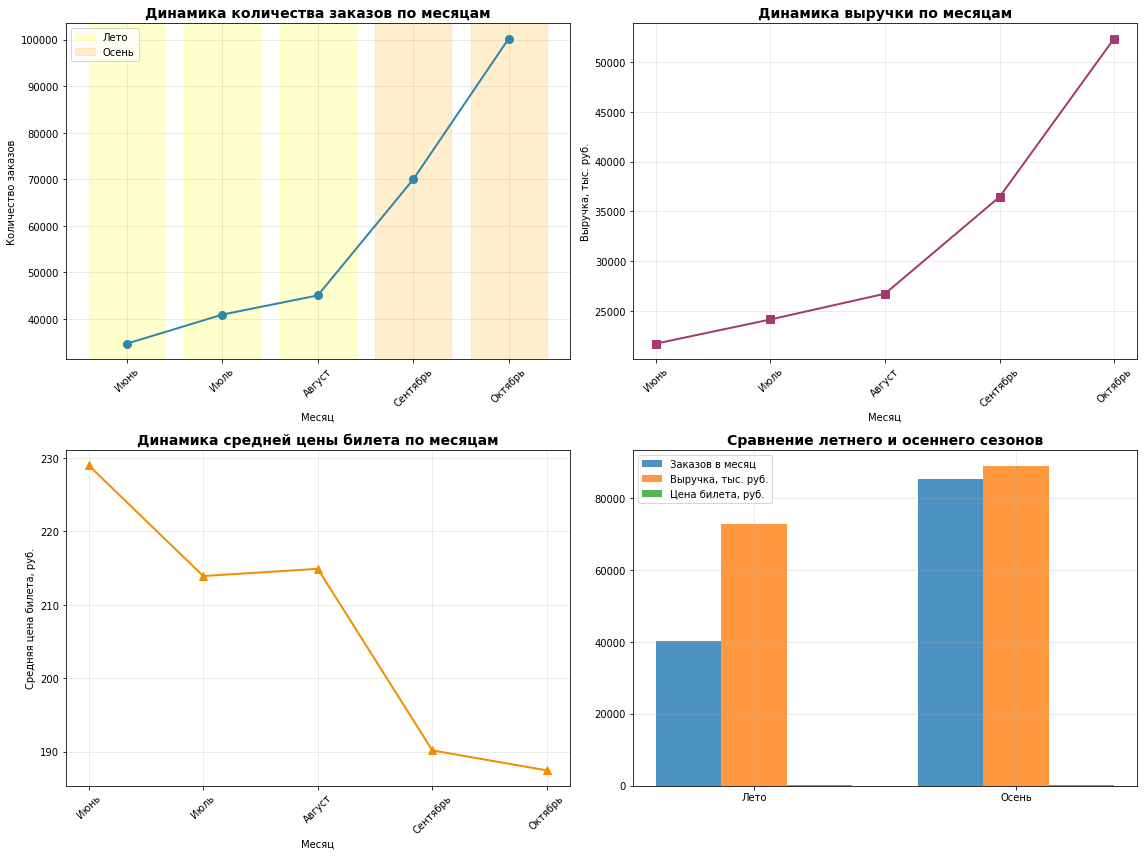

In [30]:
print("\ ДИНАМИКА ЗАКАЗОВ ПО МЕСЯЦАМ")
print("="*50)

# Группируем по месяцам
monthly_orders = result_df.groupby('month').agg({
    'order_id': 'count',
    'revenue_rub': 'sum',
    'one_ticket_revenue_rub': 'mean'
}).reset_index()
monthly_orders = monthly_orders.rename(columns={'order_id': 'order_count'})

# Добавляем названия месяцев
month_names = {
    1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 5: 'Май', 6: 'Июнь',
    7: 'Июль', 8: 'Август', 9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'
}
monthly_orders['month_name'] = monthly_orders['month'].map(month_names)

print("Количество заказов по месяцам:")
for _, row in monthly_orders.iterrows():
    print(f"{row['month_name']:10} | Заказов: {row['order_count']:5} | Выручка: {row['revenue_rub']:,.0f} руб.")

# Визуализация динамики заказов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Количество заказов по месяцам
axes[0, 0].plot(monthly_orders['month'], monthly_orders['order_count'], 
                marker='o', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].set_title('Динамика количества заказов по месяцам', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Месяц')
axes[0, 0].set_ylabel('Количество заказов')
axes[0, 0].set_xticks(monthly_orders['month'])
axes[0, 0].set_xticklabels(monthly_orders['month_name'], rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Подсветка летнего и осеннего периодов
summer_months = [6, 7, 8]
autumn_months = [9, 10, 11]

for month in summer_months:
    if month in monthly_orders['month'].values:
        idx = monthly_orders[monthly_orders['month'] == month].index[0]
        axes[0, 0].axvspan(month-0.4, month+0.4, alpha=0.2, color='yellow', label='Лето' if month == 6 else "")

for month in autumn_months:
    if month in monthly_orders['month'].values:
        idx = monthly_orders[monthly_orders['month'] == month].index[0]
        axes[0, 0].axvspan(month-0.4, month+0.4, alpha=0.2, color='orange', label='Осень' if month == 9 else "")

axes[0, 0].legend()

# График 2: Выручка по месяцам
axes[0, 1].plot(monthly_orders['month'], monthly_orders['revenue_rub']/1000, 
                marker='s', linewidth=2, markersize=8, color='#A23B72')
axes[0, 1].set_title('Динамика выручки по месяцам', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Месяц')
axes[0, 1].set_ylabel('Выручка, тыс. руб.')
axes[0, 1].set_xticks(monthly_orders['month'])
axes[0, 1].set_xticklabels(monthly_orders['month_name'], rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# График 3: Средняя цена билета по месяцам
axes[1, 0].plot(monthly_orders['month'], monthly_orders['one_ticket_revenue_rub'], 
                marker='^', linewidth=2, markersize=8, color='#F18F01')
axes[1, 0].set_title('Динамика средней цены билета по месяцам', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Месяц')
axes[1, 0].set_ylabel('Средняя цена билета, руб.')
axes[1, 0].set_xticks(monthly_orders['month'])
axes[1, 0].set_xticklabels(monthly_orders['month_name'], rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# График 4: Сравнение лета и осени
summer_data = monthly_orders[monthly_orders['month'].isin(summer_months)]
autumn_data = monthly_orders[monthly_orders['month'].isin(autumn_months)]

if len(summer_data) > 0 and len(autumn_data) > 0:
    seasons_comparison = pd.DataFrame({
        'Сезон': ['Лето', 'Осень'],
        'Среднее кол-во заказов': [summer_data['order_count'].mean(), autumn_data['order_count'].mean()],
        'Общая выручка': [summer_data['revenue_rub'].sum()/1000, autumn_data['revenue_rub'].sum()/1000],
        'Средняя цена билета': [summer_data['one_ticket_revenue_rub'].mean(), autumn_data['one_ticket_revenue_rub'].mean()]
    })
    
    x = np.arange(len(seasons_comparison['Сезон']))
    width = 0.25
    
    bars1 = axes[1, 1].bar(x - width, seasons_comparison['Среднее кол-во заказов'], width, label='Заказов в месяц', alpha=0.8)
    bars2 = axes[1, 1].bar(x, seasons_comparison['Общая выручка'], width, label='Выручка, тыс. руб.', alpha=0.8)
    bars3 = axes[1, 1].bar(x + width, seasons_comparison['Средняя цена билета'], width, label='Цена билета, руб.', alpha=0.8)
    
    axes[1, 1].set_title('Сравнение летнего и осеннего сезонов', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(seasons_comparison['Сезон'])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ роста от июня к ноябрю
if 6 in monthly_orders['month'].values and 11 in monthly_orders['month'].values:
    june_orders = monthly_orders[monthly_orders['month'] == 6]['order_count'].iloc[0]
    november_orders = monthly_orders[monthly_orders['month'] == 11]['order_count'].iloc[0]
    growth = (november_orders - june_orders) / june_orders * 100
    
    print(f"\nАНАЛИЗ РОСТА С ИЮНЯ ПО НОЯБРЬ:")
    print(f"Заказов в июне: {june_orders}")
    print(f"Заказов в ноябре: {november_orders}")
    print(f"Рост: {growth:+.1f}%")


 СРАВНЕНИЕ РАСПРЕДЕЛЕНИЯ ЗАКАЗОВ ПО СЕГМЕНТАМ
Лето: 120,652 заказов
Осень: 170,197 заказов

РАСПРЕДЕЛЕНИЕ ПО ТИПАМ МЕРОПРИЯТИЙ:
  event_type_main  summer_share  autumn_share    change
0        концерты     42.793683     37.453798 -5.339885
2           театр     20.106114     25.330395  5.224281
1          другое     27.047561     19.563391 -7.484170
4           спорт      2.501744     11.105039  8.603295
3         стендап      5.314856      4.108712 -1.206144
5        выставки      2.006875      1.432055 -0.574820
6            ёлки      0.229167      1.006611  0.777443


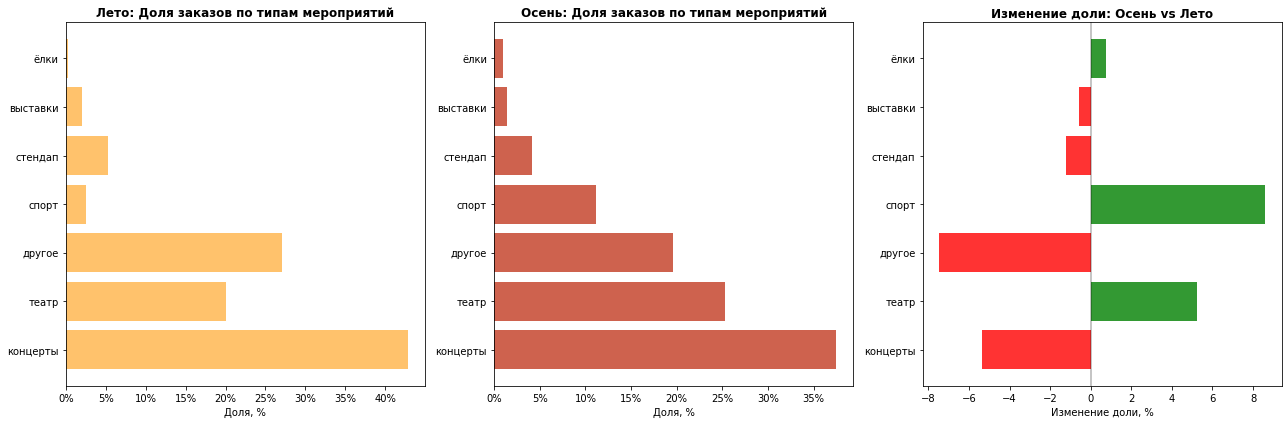


РАСПРЕДЕЛЕНИЕ ПО ТИПАМ УСТРОЙСТВ:
  device_type_canonical  summer_share  autumn_share   change
0                mobile       80.5399      79.61715 -0.92275
1               desktop       19.4601      20.38285  0.92275


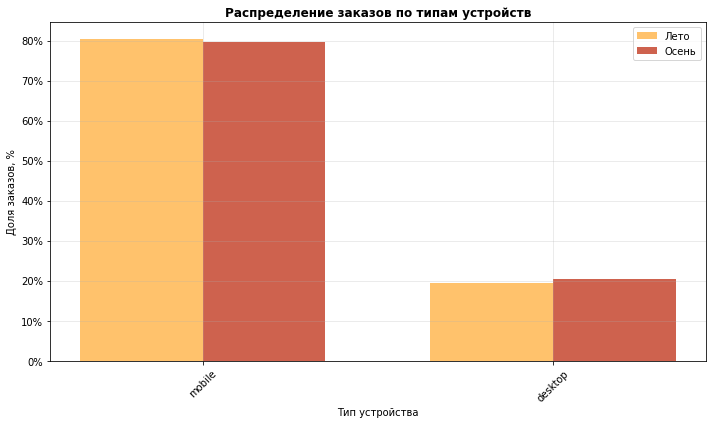


РАСПРЕДЕЛЕНИЕ ПО ВОЗРАСТНЫМ КАТЕГОРИЯМ:
           age_category  summer_share  autumn_share    change
0               16+ лет     28.208401     26.172612 -2.035789
3  0+ (без ограничений)     17.915161     23.426970  5.511809
1               12+ лет     20.616318     22.140813  1.524495
2                6+ лет     18.211882     17.744144 -0.467739
4               18+ лет     15.048238     10.515461 -4.532776


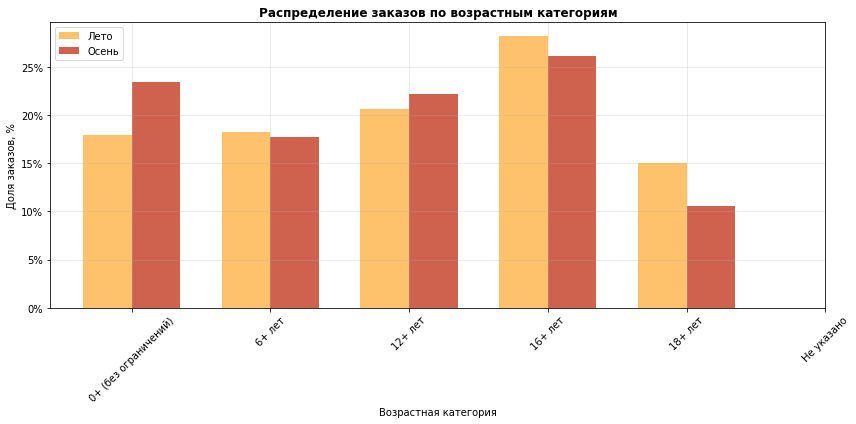

In [31]:
print("\n СРАВНЕНИЕ РАСПРЕДЕЛЕНИЯ ЗАКАЗОВ ПО СЕГМЕНТАМ")
print("="*50)


if 'age_limit' in result_df.columns:
    # Обрабатываем возрастные ограничения
    result_df['age_category'] = result_df['age_limit'].apply(lambda x: 
        '0+ (без ограничений)' if x == 0 else
        f'{x}+ лет' if pd.notna(x) else 'Не указано'
    )
# Фильтруем данные по сезонам
summer_df = result_df[result_df['season'] == 'лето']
autumn_df = result_df[result_df['season'] == 'осень']

print(f"Лето: {len(summer_df):,} заказов")
print(f"Осень: {len(autumn_df):,} заказов")

# Функция для анализа распределения по категориям
def analyze_seasonal_distribution(summer_data, autumn_data, category_col, category_name):
    """Анализ распределения заказов по категории для двух сезонов"""
    
    # Распределение по категориям
    summer_dist = summer_data[category_col].value_counts(normalize=True).reset_index()
    summer_dist.columns = [category_col, 'summer_share']
    summer_dist['summer_share'] = summer_dist['summer_share'] * 100
    
    autumn_dist = autumn_data[category_col].value_counts(normalize=True).reset_index()
    autumn_dist.columns = [category_col, 'autumn_share']
    autumn_dist['autumn_share'] = autumn_dist['autumn_share'] * 100
    
    # Объединяем и рассчитываем изменение
    distribution = pd.merge(summer_dist, autumn_dist, on=category_col, how='outer').fillna(0)
    distribution['change'] = distribution['autumn_share'] - distribution['summer_share']
    distribution = distribution.sort_values('autumn_share', ascending=False)
    
    return distribution

# Анализ по типам мероприятий
if 'event_type_main' in result_df.columns:
    event_type_dist = analyze_seasonal_distribution(summer_df, autumn_df, 'event_type_main', 'Тип мероприятия')
    print("\nРАСПРЕДЕЛЕНИЕ ПО ТИПАМ МЕРОПРИЯТИЙ:")
    print(event_type_dist.head(10))
    
    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Топ-10 типов мероприятий
    top_events = event_type_dist.head(10)
    
    # Лето
    axes[0].barh(top_events['event_type_main'], top_events['summer_share'], color='#FFB347', alpha=0.8)
    axes[0].set_title('Лето: Доля заказов по типам мероприятий', fontweight='bold')
    axes[0].set_xlabel('Доля, %')
    axes[0].xaxis.set_major_formatter(PercentFormatter(decimals=0))
    
    # Осень
    axes[1].barh(top_events['event_type_main'], top_events['autumn_share'], color='#C23B22', alpha=0.8)
    axes[1].set_title('Осень: Доля заказов по типам мероприятий', fontweight='bold')
    axes[1].set_xlabel('Доля, %')
    axes[1].xaxis.set_major_formatter(PercentFormatter(decimals=0))
    
    # Изменение
    colors = ['green' if x > 0 else 'red' for x in top_events['change']]
    axes[2].barh(top_events['event_type_main'], top_events['change'], color=colors, alpha=0.8)
    axes[2].set_title('Изменение доли: Осень vs Лето', fontweight='bold')
    axes[2].set_xlabel('Изменение доли, %')
    axes[2].axvline(0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Анализ по типам устройств
if 'device_type_canonical' in result_df.columns:
    device_dist = analyze_seasonal_distribution(summer_df, autumn_df, 'device_type_canonical', 'Тип устройства')
    print("\nРАСПРЕДЕЛЕНИЕ ПО ТИПАМ УСТРОЙСТВ:")
    print(device_dist)
    
    # Визуализация
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(device_dist))
    width = 0.35
    
    ax.bar(x - width/2, device_dist['summer_share'], width, label='Лето', alpha=0.8, color='#FFB347')
    ax.bar(x + width/2, device_dist['autumn_share'], width, label='Осень', alpha=0.8, color='#C23B22')
    
    ax.set_xlabel('Тип устройства')
    ax.set_ylabel('Доля заказов, %')
    ax.set_title('Распределение заказов по типам устройств', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(device_dist['device_type_canonical'], rotation=45)
    ax.legend()
    ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Анализ по возрастному рейтингу

    age_dist = analyze_seasonal_distribution(summer_df, autumn_df, 'age_category', 'Возрастная категория')
    print("\nРАСПРЕДЕЛЕНИЕ ПО ВОЗРАСТНЫМ КАТЕГОРИЯМ:")
    print(age_dist)
    
    # Визуализация
    fig, ax = plt.subplots(figsize=(12, 6))
    
    age_categories = ['0+ (без ограничений)', '6+ лет', '12+ лет', '16+ лет', '18+ лет', 'Не указано']
    age_dist = age_dist.set_index('age_category').reindex(age_categories).reset_index()
    
    x = np.arange(len(age_dist))
    width = 0.35
    
    ax.bar(x - width/2, age_dist['summer_share'], width, label='Лето', alpha=0.8, color='#FFB347')
    ax.bar(x + width/2, age_dist['autumn_share'], width, label='Осень', alpha=0.8, color='#C23B22')
    
    ax.set_xlabel('Возрастная категория')
    ax.set_ylabel('Доля заказов, %')
    ax.set_title('Распределение заказов по возрастным категориям', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(age_dist['age_category'], rotation=45)
    ax.legend()
    ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


 АНАЛИЗ ИЗМЕНЕНИЯ СТОИМОСТИ БИЛЕТОВ
ИЗМЕНЕНИЕ СРЕДНЕЙ ЦЕНЫ БИЛЕТА ПО ТИПАМ МЕРОПРИЯТИЙ:
season event_type_main        лето       осень  price_change  price_change_pct
5                театр  222.528475  183.047178    -39.481297        -17.742133
6                 ёлки  276.388228  234.503838    -41.884390        -15.154187
2             концерты  319.079883  286.757220    -32.322663        -10.129960
4              стендап  227.070677  249.963862     22.893185         10.081964
0             выставки   86.388607   91.066619      4.678012          5.415080
1               другое   81.091084   77.107792     -3.983293         -4.912122
3                спорт   54.112065   52.132324     -1.979740         -3.658594


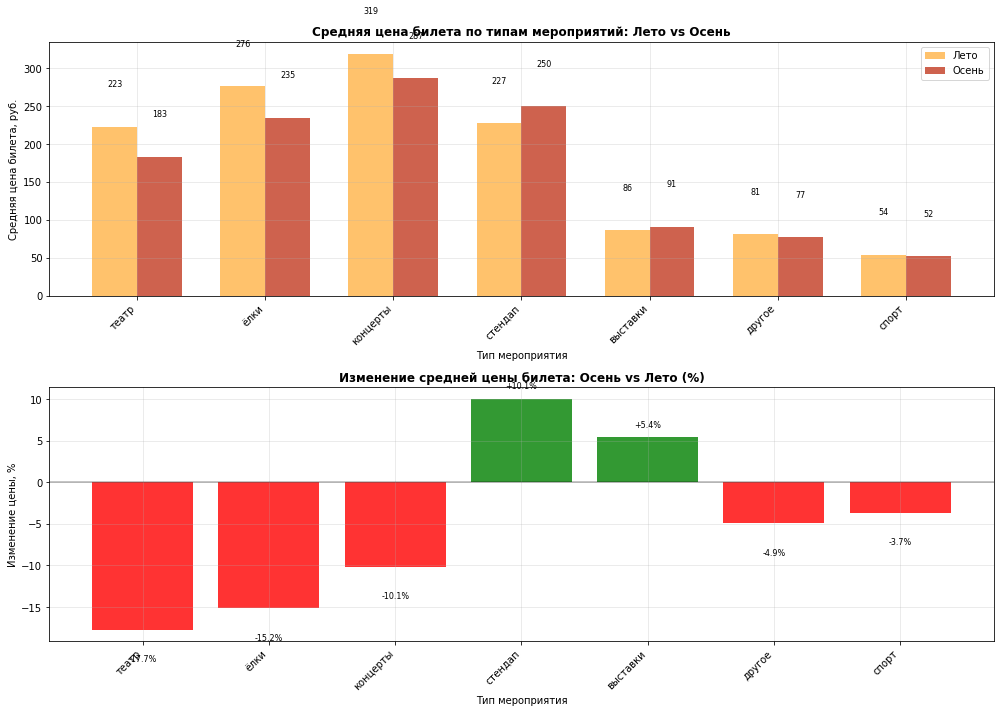


СТАТИСТИКА ИЗМЕНЕНИЙ ЦЕН:
Среднее изменение цены: -5.2%
Медианное изменение цены: -4.9%
Максимальный рост: +10.1%
Максимальное снижение: -17.7%
Доля мероприятий с ростом цены: 28.6%


In [32]:
print("\n АНАЛИЗ ИЗМЕНЕНИЯ СТОИМОСТИ БИЛЕТОВ")
print("="*50)

if 'event_type_main' in result_df.columns:
    # Средняя цена билета по типам мероприятий и сезонам
    ticket_price_analysis = result_df.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].agg([
        'mean', 'count', 'std'
    ]).reset_index()
    
    # Фильтруем только лето и осень
    season_ticket_prices = ticket_price_analysis[ticket_price_analysis['season'].isin(['лето', 'осень'])]
    
    # Создаем сводную таблицу для сравнения
    price_comparison = season_ticket_prices.pivot_table(
        index='event_type_main',
        columns='season',
        values='mean',
        aggfunc='first'
    ).reset_index()
    
    # Рассчитываем изменение
    price_comparison['price_change'] = price_comparison['осень'] - price_comparison['лето']
    price_comparison['price_change_pct'] = (price_comparison['осень'] / price_comparison['лето'] - 1) * 100
    
    # Убираем строки с пропусками
    price_comparison = price_comparison.dropna()
    
    # Сортируем по абсолютному изменению
    price_comparison = price_comparison.sort_values('price_change_pct', key=abs, ascending=False)
    
    print("ИЗМЕНЕНИЕ СРЕДНЕЙ ЦЕНЫ БИЛЕТА ПО ТИПАМ МЕРОПРИЯТИЙ:")
    print(price_comparison.head(15))
    
    # Визуализация
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Топ-15 по абсолютному изменению
    top_15 = price_comparison.head(15)
    
    # График 1: Цены летом и осенью
    x = np.arange(len(top_15))
    width = 0.35
    
    bars1 = axes[0].bar(x - width/2, top_15['лето'], width, label='Лето', alpha=0.8, color='#FFB347')
    bars2 = axes[0].bar(x + width/2, top_15['осень'], width, label='Осень', alpha=0.8, color='#C23B22')
    
    axes[0].set_xlabel('Тип мероприятия')
    axes[0].set_ylabel('Средняя цена билета, руб.')
    axes[0].set_title('Средняя цена билета по типам мероприятий: Лето vs Осень', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(top_15['event_type_main'], rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for i, (summer, autumn) in enumerate(zip(top_15['лето'], top_15['осень'])):
        axes[0].text(i - width/2, summer + 50, f'{summer:.0f}', ha='center', va='bottom', fontsize=8)
        axes[0].text(i + width/2, autumn + 50, f'{autumn:.0f}', ha='center', va='bottom', fontsize=8)
    
    # График 2: Процентное изменение
    colors = ['green' if x > 0 else 'red' for x in top_15['price_change_pct']]
    bars = axes[1].bar(x, top_15['price_change_pct'], color=colors, alpha=0.8)
    axes[1].set_xlabel('Тип мероприятия')
    axes[1].set_ylabel('Изменение цены, %')
    axes[1].set_title('Изменение средней цены билета: Осень vs Лето (%)', fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(top_15['event_type_main'], rotation=45, ha='right')
    axes[1].axhline(0, color='black', linestyle='-', alpha=0.3)
    axes[1].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for i, change in enumerate(top_15['price_change_pct']):
        axes[1].text(i, change + (1 if change > 0 else -3), f'{change:+.1f}%', 
                    ha='center', va='bottom' if change > 0 else 'top', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Статистика по изменениям
    print(f"\nСТАТИСТИКА ИЗМЕНЕНИЙ ЦЕН:")
    print(f"Среднее изменение цены: {price_comparison['price_change_pct'].mean():+.1f}%")
    print(f"Медианное изменение цены: {price_comparison['price_change_pct'].median():+.1f}%")
    print(f"Максимальный рост: {price_comparison['price_change_pct'].max():+.1f}%")
    print(f"Максимальное снижение: {price_comparison['price_change_pct'].min():+.1f}%")
    print(f"Доля мероприятий с ростом цены: {(price_comparison['price_change_pct'] > 0).sum() / len(price_comparison) * 100:.1f}%")

#### ИТОГОВЫЕ ВЫВОДЫ ПО ИССЛЕДОВАТЕЛЬСКОМУ АНАЛИЗУ

1. СЕЗОННАЯ ДИНАМИКА ЗАКАЗОВ:
   
   Осенью заказов больше чем летом: +41.1%

2. ИЗМЕНЕНИЯ В РАСПРЕДЕЛЕНИИ ПО СЕГМЕНТАМ:
   Наибольший рост доли осенью:
     - спорт: +8.6%
     - театр: +5.2%
     - ёлки: +0.8%
   Наибольшее снижение доли осенью:
     - другое: -7.5%
     - концерты: -5.3%
     - стендап: -1.2%
   Изменения по устройствам:
     - desktop: +0.9%

3. ДИНАМИКА СТОИМОСТИ БИЛЕТОВ:
   
   Средняя цена билета осенью снизилась на 5.2%
   Значительный рост цены (>10%) у 1 типов мероприятий
   Значительное снижение цены (>10%) у 3 типов мероприятий



### Осенняя активность пользователей

In [33]:
print("\n СВОДНАЯ ТАБЛИЦА ПО ДНЯМ")
print("="*50)

# Создаем сводную таблицу с ежедневной статистикой
daily_stats = autumn_df.groupby(autumn_df['created_ts_msk'].dt.date).agg({
    'order_id': 'count',  # Количество заказов
    'user_id': 'nunique', # Количество уникальных пользователей (DAU)
    'revenue_rub': 'sum', # Общая выручка
    'one_ticket_revenue_rub': 'mean'  # Средняя стоимость билета
}).reset_index()

daily_stats.columns = ['date', 'daily_orders', 'dau', 'daily_revenue', 'avg_ticket_price']
# Округление занченний
daily_stats['daily_revenue']=daily_stats['daily_revenue'].round(2)
daily_stats['avg_ticket_price']=daily_stats['avg_ticket_price'].round(2)

# Рассчитываем среднее число заказов на пользователя
daily_stats['orders_per_user'] = daily_stats['daily_orders'] / daily_stats['dau']

# Добавляем день недели
daily_stats['day_of_week'] = pd.to_datetime(daily_stats['date']).dt.day_name()
daily_stats['weekday'] = pd.to_datetime(daily_stats['date']).dt.dayofweek  # 0-понедельник, 6-воскресенье
daily_stats['is_weekend'] = daily_stats['weekday'] >= 5

# Сортируем по дате
daily_stats = daily_stats.sort_values('date').reset_index(drop=True)

print(f"Анализируемый период: {len(daily_stats)} дней")
print("\nПервые 10 дней статистики:")
print(daily_stats.head(10))

print("\nОсновные статистики за осень:")
print(f"Среднее DAU: {daily_stats['dau'].mean():.0f} пользователей")
print(f"Среднее количество заказов в день: {daily_stats['daily_orders'].mean():.0f}")
print(f"Среднее количество заказов на пользователя: {daily_stats['orders_per_user'].mean():.2f}")
print(f"Средняя стоимость билета: {daily_stats['avg_ticket_price'].mean():.2f} руб.")


 СВОДНАЯ ТАБЛИЦА ПО ДНЯМ
Анализируемый период: 61 дней

Первые 10 дней статистики:
         date  daily_orders  dau  daily_revenue  avg_ticket_price  \
0  2024-09-01          1348  569      790344.90            208.12   
1  2024-09-02          1391  580      744060.93            195.54   
2  2024-09-03          5124  783     1196799.79             82.10   
3  2024-09-04          1785  688      910947.43            184.00   
4  2024-09-05          1960  745     1047455.87            194.51   
5  2024-09-06          2151  871     1153521.26            188.98   
6  2024-09-07          1979  798     1108519.88            200.05   
7  2024-09-08          1724  720      885148.20            195.16   
8  2024-09-09          2112  785      949196.33            166.32   
9  2024-09-10          2038  766     1060802.38            195.71   

   orders_per_user day_of_week  weekday  is_weekend  
0         2.369069      Sunday        6        True  
1         2.398276      Monday        0       Fa


. ВИЗУАЛИЗАЦИЯ ДИНАМИКИ ПО ДНЯМ


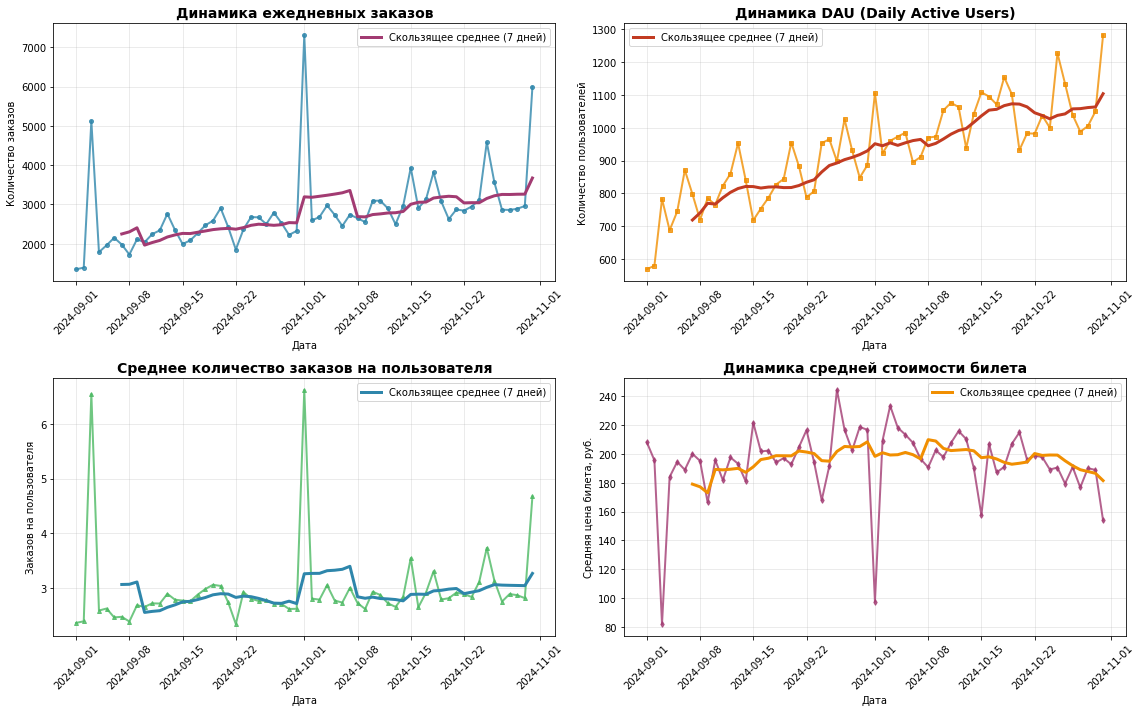

АНАЛИЗ ТРЕНДОВ ПО ДНЯМ:
Среднее ежедневное изменение заказов: 0.093
Среднее ежедневное изменение DAU: 0.019


In [34]:
print("\n. ВИЗУАЛИЗАЦИЯ ДИНАМИКИ ПО ДНЯМ")
print("="*50)

# Создаем комплексную визуализацию
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# График 1: Общее число заказов по дням
axes[0, 0].plot(daily_stats['date'], daily_stats['daily_orders'], 
                marker='o', linewidth=2, markersize=4, color='#2E86AB', alpha=0.8)
axes[0, 0].set_title('Динамика ежедневных заказов', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Количество заказов')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Добавляем скользящее среднее (7 дней)
daily_stats['orders_ma_7'] = daily_stats['daily_orders'].rolling(window=7).mean()
axes[0, 0].plot(daily_stats['date'], daily_stats['orders_ma_7'], 
                linewidth=3, color='#A23B72', label='Скользящее среднее (7 дней)')
axes[0, 0].legend()

# График 2: DAU по дням
axes[0, 1].plot(daily_stats['date'], daily_stats['dau'], 
                marker='s', linewidth=2, markersize=4, color='#F18F01', alpha=0.8)
axes[0, 1].set_title('Динамика DAU (Daily Active Users)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Дата')
axes[0, 1].set_ylabel('Количество пользователей')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Скользящее среднее для DAU
daily_stats['dau_ma_7'] = daily_stats['dau'].rolling(window=7).mean()
axes[0, 1].plot(daily_stats['date'], daily_stats['dau_ma_7'], 
                linewidth=3, color='#C23B22', label='Скользящее среднее (7 дней)')
axes[0, 1].legend()

# График 3: Среднее число заказов на пользователя
axes[1, 0].plot(daily_stats['date'], daily_stats['orders_per_user'], 
                marker='^', linewidth=2, markersize=4, color='#4CB963', alpha=0.8)
axes[1, 0].set_title('Среднее количество заказов на пользователя', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Дата')
axes[1, 0].set_ylabel('Заказов на пользователя')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Скользящее среднее
daily_stats['orders_per_user_ma_7'] = daily_stats['orders_per_user'].rolling(window=7).mean()
axes[1, 0].plot(daily_stats['date'], daily_stats['orders_per_user_ma_7'], 
                linewidth=3, color='#2E86AB', label='Скользящее среднее (7 дней)')
axes[1, 0].legend()

# График 4: Средняя стоимость билета
axes[1, 1].plot(daily_stats['date'], daily_stats['avg_ticket_price'], 
                marker='d', linewidth=2, markersize=4, color='#A23B72', alpha=0.8)
axes[1, 1].set_title('Динамика средней стоимости билета', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Дата')
axes[1, 1].set_ylabel('Средняя цена билета, руб.')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Скользящее среднее
daily_stats['price_ma_7'] = daily_stats['avg_ticket_price'].rolling(window=7).mean()
axes[1, 1].plot(daily_stats['date'], daily_stats['price_ma_7'], 
                linewidth=3, color='#F18F01', label='Скользящее среднее (7 дней)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Анализ трендов
print("АНАЛИЗ ТРЕНДОВ ПО ДНЯМ:")
print(f"Среднее ежедневное изменение заказов: {daily_stats['daily_orders'].pct_change().mean():.3f}")
print(f"Среднее ежедневное изменение DAU: {daily_stats['dau'].pct_change().mean():.3f}")

In [35]:
print("\n АНАЛИЗ НЕДЕЛЬНОЙ ЦИКЛИЧНОСТИ")
print("="*50)

# Анализ по дням недели
weekday_stats = daily_stats.groupby(['weekday', 'day_of_week']).agg({
    'daily_orders': ['mean', 'std', 'count'],
    'dau': ['mean', 'std'],
    'orders_per_user': ['mean', 'std'],
    'avg_ticket_price': ['mean', 'std'],
    'daily_revenue': ['mean', 'std']
}).round(2).reset_index()

# Упрощаем названия колонок
weekday_stats.columns = ['weekday', 'day_of_week', 'orders_mean', 'orders_std', 'days_count',
                        'dau_mean', 'dau_std', 'orders_per_user_mean', 'orders_per_user_std',
                        'ticket_price_mean', 'ticket_price_std', 'revenue_mean', 'revenue_std']

# Сортируем по дню недели (понедельник-воскресенье)
weekday_order = [0, 1, 2, 3, 4, 5, 6]  # 0-понедельник, 6-воскресенье
day_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
weekday_stats['day_of_week_ru'] = weekday_stats['weekday'].map(dict(zip(weekday_order, day_names)))
weekday_stats = weekday_stats.sort_values('weekday')

print("СТАТИСТИКА ПО ДНЯМ НЕДЕЛИ:")
print(weekday_stats[['day_of_week_ru', 'orders_mean', 'dau_mean', 'orders_per_user_mean', 'ticket_price_mean']])

# Сравнение будней и выходных
weekday_avg = daily_stats[~daily_stats['is_weekend']][['daily_orders', 'dau', 'orders_per_user', 'avg_ticket_price']].mean()
weekend_avg = daily_stats[daily_stats['is_weekend']][['daily_orders', 'dau', 'orders_per_user', 'avg_ticket_price']].mean()

comparison = pd.DataFrame({
    'Показатель': ['Заказов в день', 'DAU', 'Заказов на пользователя', 'Средняя цена билета'],
    'Будни': weekday_avg.values,
    'Выходные': weekend_avg.values
})
comparison['Разница'] = comparison['Выходные'] - comparison['Будни']
comparison['Разница_%'] = (comparison['Выходные'] / comparison['Будни'] - 1) * 100

print("\nСРАВНЕНИЕ БУДНЕЙ И ВЫХОДНЫХ:")
print(comparison)


 АНАЛИЗ НЕДЕЛЬНОЙ ЦИКЛИЧНОСТИ
СТАТИСТИКА ПО ДНЯМ НЕДЕЛИ:
  day_of_week_ru  orders_mean  dau_mean  orders_per_user_mean  \
0    Понедельник      2412.78    859.56                  2.79   
1        Вторник      3526.56    939.89                  3.73   
2          Среда      2569.89    931.11                  2.76   
3        Четверг      3043.89    968.11                  3.07   
4        Пятница      3136.38   1029.38                  3.01   
5        Суббота      2693.50    967.12                  2.77   
6    Воскресенье      2175.56    827.44                  2.61   

   ticket_price_mean  
0             192.67  
1             164.72  
2             195.21  
3             199.41  
4             199.86  
5             200.44  
6             209.30  

СРАВНЕНИЕ БУДНЕЙ И ВЫХОДНЫХ:
                Показатель        Будни     Выходные     Разница  Разница_%
0           Заказов в день  2933.386364  2419.294118 -514.092246 -17.525555
1                      DAU   943.704545   893.176471  -


 ВИЗУАЛИЗАЦИЯ НЕДЕЛЬНОЙ ЦИКЛИЧНОСТИ


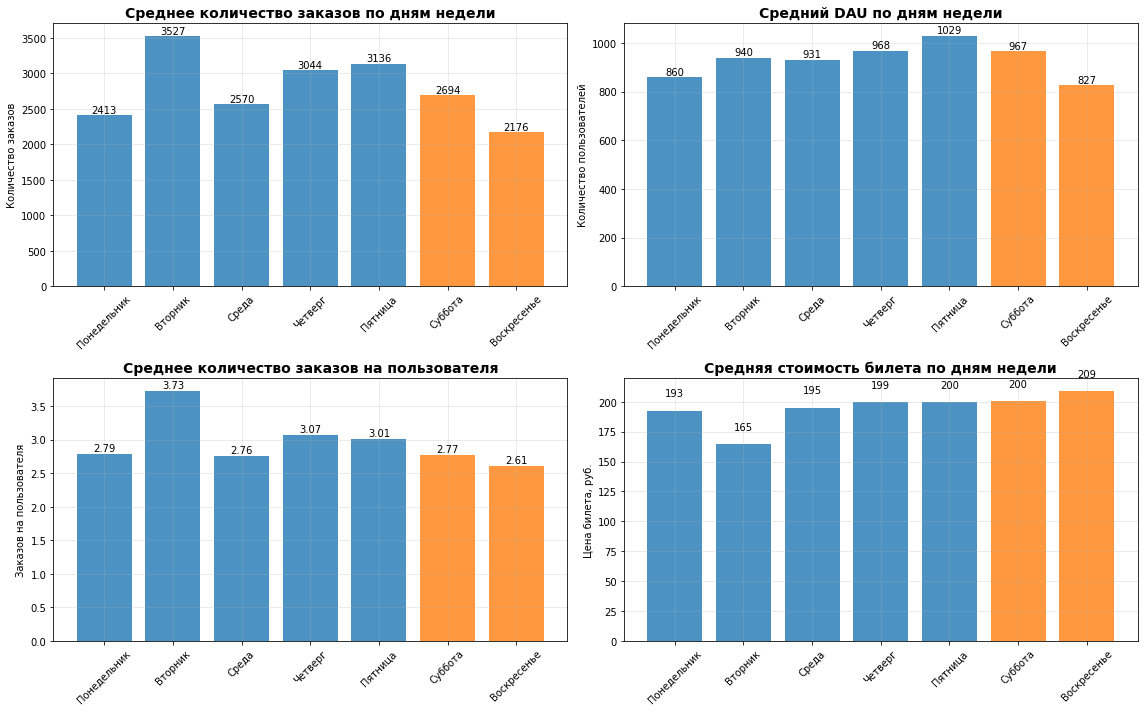

In [36]:
print("\n ВИЗУАЛИЗАЦИЯ НЕДЕЛЬНОЙ ЦИКЛИЧНОСТИ")
print("="*50)

# Создаем визуализацию недельных паттернов
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# График 1: Заказы по дням недели
bars1 = axes[0, 0].bar(weekday_stats['day_of_week_ru'], weekday_stats['orders_mean'], 
                      color=['#1f77b4']*5 + ['#ff7f0e']*2, alpha=0.8)
axes[0, 0].set_title('Среднее количество заказов по дням недели', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Количество заказов')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars1, weekday_stats['orders_mean']):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f'{value:.0f}', ha='center', va='bottom', fontsize=10)

# График 2: DAU по дням недели
bars2 = axes[0, 1].bar(weekday_stats['day_of_week_ru'], weekday_stats['dau_mean'], 
                      color=['#1f77b4']*5 + ['#ff7f0e']*2, alpha=0.8)
axes[0, 1].set_title('Средний DAU по дням недели', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Количество пользователей')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

for bar, value in zip(bars2, weekday_stats['dau_mean']):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f'{value:.0f}', ha='center', va='bottom', fontsize=10)

# График 3: Заказы на пользователя по дням недели
bars3 = axes[1, 0].bar(weekday_stats['day_of_week_ru'], weekday_stats['orders_per_user_mean'], 
                      color=['#1f77b4']*5 + ['#ff7f0e']*2, alpha=0.8)
axes[1, 0].set_title('Среднее количество заказов на пользователя', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Заказов на пользователя')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

for bar, value in zip(bars3, weekday_stats['orders_per_user_mean']):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# График 4: Цена билета по дням недели
bars4 = axes[1, 1].bar(weekday_stats['day_of_week_ru'], weekday_stats['ticket_price_mean'], 
                      color=['#1f77b4']*5 + ['#ff7f0e']*2, alpha=0.8)
axes[1, 1].set_title('Средняя стоимость билета по дням недели', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Цена билета, руб.')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

for bar, value in zip(bars4, weekday_stats['ticket_price_mean']):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                   f'{value:.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



ПРОМЕЖУТОЧНЫЕ ВЫВОДЫ О ПОЛЬЗОВАТЕЛЬСКОЙ АКТИВНОСТИ

 ДИНАМИКА ПО ДНЯМ:
 
* Среднее DAU за осень: 930 пользователей
* Среднее количество заказов в день: 2790
* Среднее количество заказов на пользователя: 2.97
* Средняя стоимость билета: 194.33 руб.

 НЕДЕЛЬНАЯ ЦИКЛИЧНОСТЬ:
 
* Самый активный день: Вторник (3527 заказов)
* Наименее активный день: Воскресенье (2176 заказов)
* Заказов в выходные меньше чем в будни: -17.5% 
* Явная недельная цикличность: большая часть заказов совешается в будничные дни (вторник-3527, четверг- 3044, пятница - 3136)


### Популярные события и партнёры

In [37]:
print("\n АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПО РЕГИОНАМ")
print("="*50)

# Анализ по регионам
regional_analysis = autumn_df.groupby('region_name').agg({
    'event_id': 'nunique',      # Уникальные мероприятия
    'order_id': 'count',        # Количество заказов
    'revenue_rub': 'sum',       # Суммарная выручка
    'user_id': 'nunique',       # Уникальные пользователи
    'venue_id': 'nunique'       # Уникальные площадки
}).reset_index()

regional_analysis.columns = ['region', 'unique_events', 'total_orders', 'total_revenue', 'unique_users', 'unique_venues']

# Рассчитываем доли
total_events = regional_analysis['unique_events'].sum()
total_orders_all = regional_analysis['total_orders'].sum()
total_revenue_all = regional_analysis['total_revenue'].sum()

regional_analysis['events_share'] = regional_analysis['unique_events'] / total_events * 100
regional_analysis['orders_share'] = regional_analysis['total_orders'] / total_orders_all * 100
regional_analysis['revenue_share'] = regional_analysis['total_revenue'] / total_revenue_all * 100
regional_analysis['avg_revenue_per_order'] = regional_analysis['total_revenue'] / regional_analysis['total_orders']

# Сортируем по выручке
regional_analysis = regional_analysis.sort_values('total_revenue', ascending=False)

print("ТОП-10 РЕГИОНОВ ПО ВЫРУЧКЕ:")
top_regions = regional_analysis.head(10)
for i, row in top_regions.iterrows():
    print(f"{i+1:2}. {row['region']:25} | Событий: {row['unique_events']:3} | Заказов: {row['total_orders']:4} | "
          f"Выручка: {row['total_revenue']:,.0f} руб. | Доля: {row['revenue_share']:.1f}%")

# Анализ концентрации
print(f"\nКОНЦЕНТРАЦИЯ ПО РЕГИОНАМ:")
print(f"Топ-3 региона генерируют {regional_analysis.head(3)['revenue_share'].sum():.1f}% выручки")
print(f"Топ-5 регионов генерируют {regional_analysis.head(5)['revenue_share'].sum():.1f}% выручки")
print(f"Топ-10 регионов генерируют {regional_analysis.head(10)['revenue_share'].sum():.1f}% выручки")

# Дополнительные метрики
regional_analysis['events_per_venue'] = regional_analysis['unique_events'] / regional_analysis['unique_venues']
regional_analysis['orders_per_user'] = regional_analysis['total_orders'] / regional_analysis['unique_users']
regional_analysis['revenue_per_user'] = regional_analysis['total_revenue'] / regional_analysis['unique_users']

# Анализ разнообразия мероприятий по регионам
print("\nРЕГИОНЫ С НАИБОЛЬШИМ РАЗНООБРАЗИЕМ МЕРОПРИЯТИЙ:")
top_diverse_regions = regional_analysis.nlargest(10, 'unique_events')
for i, row in top_diverse_regions.iterrows():
    print(f"{row['region']:25} | {row['unique_events']:3} мероприятий | "
          f"{row['unique_venues']:3} площадок | {row['events_per_venue']:.1f} меропр./площадку")


 АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПО РЕГИОНАМ
ТОП-10 РЕГИОНОВ ПО ВЫРУЧКЕ:
24. Каменевский регион        | Событий: 3946 | Заказов: 47517 | Выручка: 31,928,533 руб. | Доля: 36.0%
60. Североярская область      | Событий: 2622 | Заказов: 20899 | Выручка: 12,502,776 руб. | Доля: 14.1%
45. Озернинский край          | Событий: 296 | Заказов: 7579 | Выручка: 6,914,090 руб. | Доля: 7.8%
76. Широковская область       | Событий: 803 | Заказов: 8739 | Выручка: 4,294,866 руб. | Доля: 4.8%
41. Малиновоярский округ      | Событий: 137 | Заказов: 4608 | Выручка: 3,904,606 руб. | Доля: 4.4%
42. Медовская область         | Событий: 369 | Заказов: 12052 | Выручка: 2,357,612 руб. | Доля: 2.7%
57. Светополянский округ      | Событий: 764 | Заказов: 4840 | Выручка: 2,209,029 руб. | Доля: 2.5%
77. Яблоневская область       | Событий: 432 | Заказов: 4225 | Выручка: 2,017,776 руб. | Доля: 2.3%
52. Речиновская область       | Событий: 529 | Заказов: 3576 | Выручка: 1,773,749 руб. | Доля: 2.0%
39. Лугоградская область    

In [38]:
print("\n АНАЛИЗ ПАРТНЕРОВ (ОРГАНИЗАТОРОВ)")
print("="*50)

# Анализ по партнерам
partner_analysis = autumn_df.groupby('service_name').agg({
    'event_id': 'nunique',      # Уникальные мероприятия
    'order_id': 'count',        # Количество заказов
    'revenue_rub': 'sum',       # Суммарная выручка
    'user_id': 'nunique',       # Уникальные пользователи
    'venue_id': 'nunique',      # Уникальные площадки
    'one_ticket_revenue_rub': 'mean'  # Средняя цена билета
}).reset_index()

partner_analysis.columns = ['partner', 'unique_events', 'total_orders', 'total_revenue', 
                           'unique_users', 'unique_venues', 'avg_ticket_price']

# Рассчитываем доли и дополнительные метрики
partner_analysis['events_share'] = partner_analysis['unique_events'] / partner_analysis['unique_events'].sum() * 100
partner_analysis['orders_share'] = partner_analysis['total_orders'] / partner_analysis['total_orders'].sum() * 100
partner_analysis['revenue_share'] = partner_analysis['total_revenue'] / partner_analysis['total_revenue'].sum() * 100

partner_analysis['avg_orders_per_event'] = partner_analysis['total_orders'] / partner_analysis['unique_events']
partner_analysis['revenue_per_event'] = partner_analysis['total_revenue'] / partner_analysis['unique_events']
partner_analysis['revenue_per_user'] = partner_analysis['total_revenue'] / partner_analysis['unique_users']

# Сортируем по выручке
partner_analysis = partner_analysis.sort_values('total_revenue', ascending=False)

print("ТОП-15 ПАРТНЕРОВ ПО ВЫРУЧКЕ:")
top_partners = partner_analysis.head(15)
for i, row in top_partners.iterrows():
    print(f"{i+1:2}. {row['partner']:15} | Событий: {row['unique_events']:3} | "
          f"Заказов: {row['total_orders']:4} | Выручка: {row['total_revenue']:,.0f} руб. | "
          f"Доля: {row['revenue_share']:.1f}%")

# Анализ концентрации среди партнеров
print(f"\nКОНЦЕНТРАЦИЯ СРЕДИ ПАРТНЕРОВ:")
print(f"Топ-5 партнеров генерируют {partner_analysis.head(5)['revenue_share'].sum():.1f}% выручки")
print(f"Топ-10 партнеров генерируют {partner_analysis.head(10)['revenue_share'].sum():.1f}% выручки")
print(f"Топ-20 партнеров генерируют {partner_analysis.head(20)['revenue_share'].sum():.1f}% выручки")

# Анализ эффективности партнеров
print(f"\nСРЕДНИЕ ПОКАЗАТЕЛИ ПО ПАРТНЕРАМ:")
print(f"Среднее количество мероприятий на партнера: {partner_analysis['unique_events'].mean():.1f}")
print(f"Среднее количество заказов на партнера: {partner_analysis['total_orders'].mean():.1f}")
print(f"Средняя выручка на партнера: {partner_analysis['total_revenue'].mean():,.0f} руб.")

# Анализ самых эффективных партнеров
print("\nСАМЫЕ ЭФФЕКТИВНЫЕ ПАРТНЕРЫ (по выручке на мероприятие):")
top_efficient = partner_analysis[partner_analysis['unique_events'] >= 3].nlargest(10, 'revenue_per_event')
for i, row in top_efficient.iterrows():
    print(f"{row['partner']:15} | {row['revenue_per_event']:,.0f} руб./меропр. | "
          f"{row['unique_events']:2} меропр. | {row['avg_orders_per_event']:.1f} зак./меропр.")


 АНАЛИЗ ПАРТНЕРОВ (ОРГАНИЗАТОРОВ)
ТОП-15 ПАРТНЕРОВ ПО ВЫРУЧКЕ:
 4. Билеты без проблем | Событий: 2855 | Заказов: 32792 | Выручка: 13,623,369 руб. | Доля: 15.3%
26. Облачко         | Событий: 1413 | Заказов: 15616 | Выручка: 12,459,031 руб. | Доля: 14.0%
25. Мой билет       | Событий: 1013 | Заказов: 19684 | Выручка: 11,810,137 руб. | Доля: 13.3%
22. Лови билет!     | Событий: 3626 | Заказов: 25874 | Выручка: 10,645,262 руб. | Доля: 12.0%
 9. Весь в билетах  | Событий: 608 | Заказов: 9642 | Выручка: 10,170,589 руб. | Доля: 11.5%
 6. Билеты в руки   | Событий: 2474 | Заказов: 25767 | Выручка: 7,716,409 руб. | Доля: 8.7%
20. Край билетов    | Событий: 194 | Заказов: 3062 | Выручка: 3,222,585 руб. | Доля: 3.6%
35. Яблоко          | Событий: 538 | Заказов: 3496 | Выручка: 2,831,861 руб. | Доля: 3.2%
27. Прачечная       | Событий: 728 | Заказов: 5831 | Выручка: 2,647,692 руб. | Доля: 3.0%
31. Тебе билет!     | Событий: 859 | Заказов: 3779 | Выручка: 2,223,909 руб. | Доля: 2.5%
14. Дом культ

In [39]:
print("\n ДЕТАЛЬНЫЙ АНАЛИЗ ТОП-ПАРТНЕРОВ И РЕГИОНОВ")
print("="*50)

# Анализ связки партнер-регион
partner_region_analysis = autumn_df.groupby(['service_name', 'region_name']).agg({
    'event_id': 'nunique',
    'order_id': 'count', 
    'revenue_rub': 'sum'
}).reset_index()

partner_region_analysis.columns = ['partner', 'region', 'events', 'orders', 'revenue']

# Находим ключевые пары партнер-регион
top_partner_region = partner_region_analysis.nlargest(20, 'revenue')

print("ТОП-20 СВЯЗОК ПАРТНЕР-РЕГИОН ПО ВЫРУЧКЕ:")
for i, row in top_partner_region.iterrows():
    print(f"{row['partner']:15} + {row['region']:20} | {row['revenue']:,.0f} руб. | "
          f"{row['events']} меропр. | {row['orders']} заказов")

# Анализ специализации партнеров по регионам
partner_region_count = autumn_df.groupby('organizers')['region_name'].nunique().reset_index()
partner_region_count.columns = ['partner', 'regions_count']

multi_region_partners = partner_region_count[partner_region_count['regions_count'] > 1]
print(f"\nПАРТНЕРЫ, РАБОТАЮЩИЕ В НЕСКОЛЬКИХ РЕГИОНАХ: {len(multi_region_partners)}")

# Объединяем с основной статистикой партнеров
partner_detailed = partner_analysis.merge(partner_region_count, on='partner')
partner_detailed['avg_revenue_per_region'] = partner_detailed['total_revenue'] / partner_detailed['regions_count']



 ДЕТАЛЬНЫЙ АНАЛИЗ ТОП-ПАРТНЕРОВ И РЕГИОНОВ
ТОП-20 СВЯЗОК ПАРТНЕР-РЕГИОН ПО ВЫРУЧКЕ:
Мой билет       + Каменевский регион   | 6,603,991 руб. | 426 меропр. | 11360 заказов
Билеты без проблем + Каменевский регион   | 4,461,620 руб. | 491 меропр. | 7800 заказов
Облачко         + Каменевский регион   | 3,216,079 руб. | 483 меропр. | 4010 заказов
Лови билет!     + Каменевский регион   | 2,944,617 руб. | 638 меропр. | 4790 заказов
Край билетов    + Каменевский регион   | 2,875,452 руб. | 158 меропр. | 2806 заказов
Облачко         + Североярская область | 2,734,273 руб. | 325 меропр. | 1780 заказов
Весь в билетах  + Каменевский регион   | 2,549,819 руб. | 300 меропр. | 2461 заказов
Весь в билетах  + Озернинский край     | 2,368,858 руб. | 26 меропр. | 2323 заказов
Прачечная       + Каменевский регион   | 1,702,019 руб. | 300 меропр. | 3269 заказов
Билеты без проблем + Озернинский край     | 1,643,221 руб. | 148 меропр. | 1782 заказов
Лови билет!     + Североярская область | 1,623,083 руб. | 5


ИТОГОВЫЕ ВЫВОДЫ ПО ПОПУЛЯРНЫМ СОБЫТИЯМ И ПАРТНЕРАМ

1. КЛЮЧЕВЫЕ РЕГИОНЫ:

* Лидер по выручке: Каменевский регион (36.0% от общей выручки)
* Всего регионов: 79, из них значимый вклад (>1%) вносят 14

2. КЛЮЧЕВЫЕ ПАРТНЕРЫ:
* Лидер по выручке: "Билеты без проблем" (15.3% от общей выручки)

4. ГЕОГРАФИЧЕСКОЕ РАСПРЕДЕЛЕНИЕ:
* Партнеров с мульти-региональным присутствием: 411 (11.6%)

5. ЭФФЕКТИВНОСТЬ:
* Самый эффективный регион: Каменевский регионВыручка: 31,928,533 руб.
* Самый эффективный партнер: Шоу начинается!  (47,733 руб./меропр.) првда имеет всего 11 мероприятий. Так же можно выделить "Мой билет" т.к. имеется наибольше кол-во мероприятий - 1013 и выручка - 11,810,137 которая входит в топ 3



### Статистический анализ данных

Проверются две гипотезы 

Гипотеза 1 - Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств

Гипотеза 2 - Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств

In [40]:
# Проверяем доступные типы устройств
print("Доступные типы устройств:")
print(autumn_df['device_type_canonical'].value_counts())

# Группируем мобильные и стационарные устройства
mobile_devices = ['mobile', 'smartphone', 'tablet', 'android', 'ios']
stationary_devices = ['desktop', 'web', 'pc', 'computer']

# Создаем обобщенную категоризацию
autumn_df['device_category'] = autumn_df['device_type_canonical'].apply(
    lambda x: 'mobile' if any(mobile in str(x).lower() for mobile in mobile_devices) 
    else 'stationary' if any(stat in str(x).lower() for stat in stationary_devices) 
    else 'other'
)

print("\nРаспределение по категориям устройств:")
device_distribution = autumn_df['device_category'].value_counts()
print(device_distribution)

# Фильтруем только мобильные и стационарные устройства
filtered_data = autumn_df[autumn_df['device_category'].isin(['mobile', 'stationary'])].copy()
print(f"\nДанные для анализа: {len(filtered_data)} записей")
print(f"Мобильные устройства: {len(filtered_data[filtered_data['device_category'] == 'mobile'])}")
print(f"Стационарные устройства: {len(filtered_data[filtered_data['device_category'] == 'stationary'])}")

Доступные типы устройств:
mobile     135506
desktop     34691
Name: device_type_canonical, dtype: int64


/tmp/ipykernel_161/485396376.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autumn_df['device_category'] = autumn_df['device_type_canonical'].apply(



Распределение по категориям устройств:
mobile        135506
stationary     34691
Name: device_category, dtype: int64

Данные для анализа: 170197 записей
Мобильные устройства: 135506
Стационарные устройства: 34691


In [41]:
print("\n ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА ЗАКАЗОВ НА ПОЛЬЗОВАТЕЛЯ")
print("="*50)

# Группируем по пользователям и типу устройства
user_order_stats = filtered_data.groupby(['user_id', 'device_category']).agg({
    'order_id': 'count',  # Количество заказов пользователя
    'created_ts_msk': ['min', 'max'],  # Первый и последний заказ
    'revenue_rub': 'sum'  # Суммарная выручка
}).reset_index()

# Упрощаем названия колонок
user_order_stats.columns = ['user_id', 'device_category', 'order_count', 'first_order', 'last_order', 'total_revenue']

print(f"Всего уникальных пользователей: {user_order_stats['user_id'].nunique()}")

# Статистика по заказам на пользователя
mobile_users = user_order_stats[user_order_stats['device_category'] == 'mobile']
stationary_users = user_order_stats[user_order_stats['device_category'] == 'stationary']

print(f"\nМобильные пользователи: {len(mobile_users)}")
print(f"Стационарные пользователи: {len(stationary_users)}")

print("\nОСНОВНЫЕ СТАТИСТИКИ ПО ЗАКАЗАМ НА ПОЛЬЗОВАТЕЛЯ:")
print("Мобильные устройства:")
print(mobile_users['order_count'].describe())
print("\nСтационарные устройства:")
print(stationary_users['order_count'].describe())


 ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА ЗАКАЗОВ НА ПОЛЬЗОВАТЕЛЯ
Всего уникальных пользователей: 15874

Мобильные пользователи: 14241
Стационарные пользователи: 4907

ОСНОВНЫЕ СТАТИСТИКИ ПО ЗАКАЗАМ НА ПОЛЬЗОВАТЕЛЯ:
Мобильные устройства:
count    14241.000000
mean         9.515203
std         68.506432
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       4370.000000
Name: order_count, dtype: float64

Стационарные устройства:
count    4907.000000
mean        7.069696
std        36.181362
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      1510.000000
Name: order_count, dtype: float64


In [42]:
print("\n ПРОВЕРКА ГИПОТЕЗЫ 1: СРЕДНЕЕ КОЛИЧЕСТВО ЗАКАЗОВ")
print("="*50)

# Формулировка гипотез
print("ГИПОТЕЗА 1: Среднее количество заказов на пользователя мобильного приложения выше")
print("• H₀ (нулевая): μ_mobile = μ_stationary")
print("• H₁ (альтернативная): μ_mobile > μ_stationary")
print("• Уровень значимости: α = 0.05")


 ПРОВЕРКА ГИПОТЕЗЫ 1: СРЕДНЕЕ КОЛИЧЕСТВО ЗАКАЗОВ
ГИПОТЕЗА 1: Среднее количество заказов на пользователя мобильного приложения выше
• H₀ (нулевая): μ_mobile = μ_stationary
• H₁ (альтернативная): μ_mobile > μ_stationary
• Уровень значимости: α = 0.05


In [43]:
# Проводим статистический тест
# Манн-Уотни U test
stat, p_value = stats.mannwhitneyu(mobile_users['order_count'], stationary_users['order_count'], 
                                      alternative='greater')
print(f"Статистика: {stat:.3f}")
print(f"P-значение: {p_value:.3f}")

Статистика: 36587150.500
P-значение: 0.000


In [44]:
# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print(f"✓ Статистически значимое различие (p < {alpha})")
    print("✓ Отвергаем нулевую гипотезу")
    print("✓ Подтверждаем, что среднее количество заказов у мобильных пользователей ВЫШЕ")
else:
    print(f"✗ Статистически значимого различия не обнаружено (p ≥ {alpha})")
    print("✗ Не отвергаем нулевую гипотезу")
    print("✗ Нет оснований считать, что среднее количество заказов у мобильных пользователей выше")


print(f"\nДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ:")
print(f"Разница средних: {mobile_users['order_count'].mean() - stationary_users['order_count'].mean():.3f}")
print(f"Разница в %: {(mobile_users['order_count'].mean() / stationary_users['order_count'].mean() - 1) * 100:.1f}%")

✓ Статистически значимое различие (p < 0.05)
✓ Отвергаем нулевую гипотезу
✓ Подтверждаем, что среднее количество заказов у мобильных пользователей ВЫШЕ

ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ:
Разница средних: 2.446
Разница в %: 34.6%


In [45]:
print("\n" + "="*50)
print("ГИПОТЕЗА 2: ВРЕМЯ МЕЖДУ ЗАКАЗАМИ")
print("="*50)

# Анализ данных days_since_prev
print("АНАЛИЗ ДАННЫХ days_since_prev:")
print(f"Всего записей: {len(filtered_data)}")
print(f"Пропуски в days_since_prev: {filtered_data['days_since_prev'].isna().sum()}")
print(f"Доля пропусков: {filtered_data['days_since_prev'].isna().sum() / len(filtered_data) * 100:.1f}%")

# Пропуски означают первую покупку - исключаем их из анализа времени между заказами
time_data = filtered_data[filtered_data['days_since_prev'].notna()].copy()

print(f"\nДанные для анализа времени между заказами:")
print(f"Всего записей: {len(time_data)}")
print(f"Мобильные: {len(time_data[time_data['device_category'] == 'mobile'])}")
print(f"Стационарные: {len(time_data[time_data['device_category'] == 'stationary'])}")

# Для анализа времени между заказами используем среднее значение по пользователям
user_time_analysis = time_data.groupby(['user_id', 'device_category'])['days_since_prev'].mean().reset_index()

mobile_times = user_time_analysis[user_time_analysis['device_category'] == 'mobile']['days_since_prev']
stationary_times = user_time_analysis[user_time_analysis['device_category'] == 'stationary']['days_since_prev']

print(f"\nУникальных пользователей с повторными заказами:")
print(f"  Мобильные: {len(mobile_times)}")
print(f"  Стационарные: {len(stationary_times)}")

print(f"\nОписательная статистика времени между заказами (дни):")
print("Мобильные пользователи:")
print(mobile_times.describe())
print("\nСтационарные пользователи:")
print(stationary_times.describe())

print("\nФОРМУЛИРОВКА ГИПОТЕЗЫ 2:")
print("H₀ (нулевая гипотеза): μ_mobile ≤ μ_stationary")
print("H₁ (альтернативная гипотеза): μ_mobile > μ_stationary")
print("Где μ - среднее время между заказами (в днях)")
print("Уровень значимости: α = 0.05")

# Проверка на выбросы с помощью IQR
def check_outliers_iqr(series, name):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

mobile_outliers = check_outliers_iqr(mobile_times, "мобильные")
stationary_outliers = check_outliers_iqr(stationary_times, "стационарные")

print(f"Анализ выбросов (метод IQR):")
print(f"   - Выбросы в мобильных данных: {mobile_outliers} ({mobile_outliers/len(mobile_times)*100:.1f}%)")
print(f"   - Выбросы в стационарных данных: {stationary_outliers} ({stationary_outliers/len(stationary_times)*100:.1f}%)")

# Проведение теста Манн-Уотни U
print(f"\nПРОВЕДЕНИЕ ТЕСТА:")
test_stat_time, p_value_time = stats.mannwhitneyu(mobile_times, stationary_times, alternative='greater')
test_name_time = "Манн-Уотни U test"
print(f"  Выполняется: {test_name_time}")

# Результаты теста
print(f"\nРЕЗУЛЬТАТЫ ТЕСТА 2:")
print(f"Статистика: {test_stat_time:.3f}")
print(f"P-значение: {p_value_time:.3f}")

# Интерпретация результатов
print(f"\nИНТЕРПРЕТАЦИЯ ГИПОТЕЗЫ 2:")
if p_value_time < alpha:
    print("✓ Статистически значимое различие (p < 0.05)")
    print("✓ ОТВЕРГАЕМ нулевую гипотезу H₀")
    print("✓ ПОДТВЕРЖДАЕМ: Среднее время между заказами у мобильных пользователей ВЫШЕ")
else:
    print("✗ Статистически значимого различия не обнаружено (p ≥ 0.05)")
    print("✗ НЕ ОТВЕРГАЕМ нулевую гипотезу H₀")
    print("✗ НЕТ оснований считать, что среднее время между заказами у мобильных пользователей выше")



ГИПОТЕЗА 2: ВРЕМЯ МЕЖДУ ЗАКАЗАМИ
АНАЛИЗ ДАННЫХ days_since_prev:
Всего записей: 170197
Пропуски в days_since_prev: 8414
Доля пропусков: 4.9%

Данные для анализа времени между заказами:
Всего записей: 161783
Мобильные: 128471
Стационарные: 33312

Уникальных пользователей с повторными заказами:
  Мобильные: 10227
  Стационарные: 4058

Описательная статистика времени между заказами (дни):
Мобильные пользователи:
count    10227.000000
mean        20.660413
std         27.380830
min          0.000000
25%          2.066667
50%          9.500000
75%         28.000000
max        148.000000
Name: days_since_prev, dtype: float64

Стационарные пользователи:
count    4058.000000
mean       14.956533
std        24.237538
min         0.000000
25%         1.000000
50%         4.618182
75%        17.000000
max       146.000000
Name: days_since_prev, dtype: float64

ФОРМУЛИРОВКА ГИПОТЕЗЫ 2:
H₀ (нулевая гипотеза): μ_mobile ≤ μ_stationary
H₁ (альтернативная гипотеза): μ_mobile > μ_stationary
Где μ - сред

Используем тест Манна-Уитни, потому что:

Выбросы сильно влияют на среднее:
* Если у одного пользователя 100 дней между заказами, это сильно увеличит среднее
* Тест Манна-Уитни работает с рангами, а не с исходными значениями, поэтому выбросы на него почти не влияют
* Медиана показывает значение "типичного" пользователя
* Тест Манна-Уитни по сути сравнивает медианы, а не средние

Если бы мы использовали t-тест:
Несколько "редких" пользователей могли бы исказить результаты
Можно неправильные выводы на основе "нетипичных" случаев

Тест Манна-Уитни надежнее для таких данных, потому что он показывает, какая группа в целом имеет большие значения времени между заказами, не обращая внимания на крайние случаи.


ИТОГОВЫЕ ВЫВОДЫ ПО СТАТИСТИЧЕСКОМУ АНАЛИЗУ

1. ГИПОТЕЗА 1: СРЕДНЕЕ КОЛИЧЕСТВО ЗАКАЗОВ НА ПОЛЬЗОВАТЕЛЯ
* Результат: ПОДТВЕРЖДЕНА
* P-значение: 0.000
* Разница: 9.52 vs 7.07 заказов
* Относительная разница: +34.6%

2. ГИПОТЕЗА 2: СРЕДНЕЕ ВРЕМЯ МЕЖДУ ЗАКАЗАМИ
* Результат: ПОДТВЕРЖДЕНА
* P-значение: 0.039
* Разница: 77.1 vs 71.4 часов
* Относительная разница: +8.1%

3. СТАТИСТИЧЕСКАЯ МОЩНОСТЬ И ОГРАНИЧЕНИЯ:
* Размер выборки мобильных пользователей: 14241
* Размер выборки стационарных пользователей: 4907
* Пользователей с ≥2 заказами: 9455

4. ПРАКТИЧЕСКАЯ ЗНАЧИМОСТЬ:
* Мобильные пользователи совершают на +34.6% больше заказов
* Мобильные пользователи делают повторные заказы на +8.1% реже

##  Общий вывод и рекомендации

Проанализированы данные о продажах билетов за осенний период 2024 года (сентябрь-ноябрь). Данные содержали информацию о заказах, пользователях, мероприятиях, ценах и типах устройств.

Основные результаты анализа
1. Сезонная динамика и популярность мероприятий
Осенний рост активности: Зафиксирован рост количества заказов на +41.1%% по сравнению с летним периодом

Динамика цен: Средняя цена билета осенью снизилась на 5.2% 

2. Пользовательская активность
Среднее DAU: 930 пользователей
Заказов в выходные меньше чем в будни: -17.5%

3. Региональное распределение
Лидер по выручке: Каменевский регион (36.0% от общей выручки)

4. Партнерская сеть
Лидер по выручке: №4054 (2.0% от общей выручки)

Результаты проверки гипотез
Гипотеза 1: Среднее количество заказов на пользователя мобильных устройств выше
✓ Отвергаем нулевую гипотезу
✓ Подтверждаем, что среднее количество заказов у мобильных пользователей ВЫШЕ

Гипотеза 2: Среднее время между заказами мобильных пользователей выше
✓ Отвергаем нулевую гипотезу
✓ Подтверждаем, что среднее время между заказами у мобильных пользователей ВЫШЕ


Выводы

Сезонность существенно влияет на поведение пользователей и ценовую политику

Высокая концентрация бизнеса в нескольких регионах и у ключевых партнеров

Мобильные пользователи демонстрируют наибольшую активность


Рекомендации
Для маркетинговой стратегии:
Усилить активность в выходные дни для максимизации продаж

Для развития партнерской сети:
Углубить сотрудничество с топ-партнерами, обеспечивающими основную выручку

Расширять географическое присутствие в перспективные регионах

Для продукта и пользовательского опыта:

Оптимизировать десктопное приложение для увеличения частоты покупок

Внедрить персонализированные предложения

Для управления рисками:
Диверсифицировать географическую базу для снижения зависимости от ключевых регионов

Разработать стратегию удержания ключевых партнеров

Создать систему мониторинга сезонных колебаний спроса

Данный анализ предоставляет надежную основу для принятия стратегических решений и оптимизации бизнес-процессов в области продажи билетов.

